In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymaid
import logging
import random
from graspologic.match import graph_match
from graspologic.simulations import er_np
from graspologic.utils import is_unweighted
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations_v2, load_connectome_normal_lcc_annotations_v3, load_connectome_lcc_normal_adj, load_left_adj, load_right_adj, load_left_adj_labels_with_class_v2, load_right_adj_labels_with_class_v2, load_head_adj_labels_with_class_v2, load_pygidium_adj_labels_with_class_v2, load_0_adj, load_1_adj_labels_with_class_v2, load_2_adj_labels_with_class_v2, load_3_adj_labels_with_class_v2, load_left_adj_labels_with_class_v3, load_right_adj_labels_with_class_v3

967
967
919
919
724
724
79
79
317
317
395
395
323
323
        skids   side    class   segment   type  group
0     2015233   left  sensory      head  100.0    NaN
1     1548290   left   muscle         1    NaN    NaN
2     1318919   left  sensory      head   88.0   15.0
3     2015241   left  sensory      head  100.0    NaN
4     1769485  right  sensory       NaN    NaN    NaN
...       ...    ...      ...       ...    ...    ...
2028  1597423  right   muscle  pygidium    NaN    NaN
2029  1302513   left  sensory      head    NaN    NaN
2030  1671147  right    motor         1  165.0    NaN
2031  1376251   left    inter      head    NaN    NaN
2032  1048573   left    inter         3    NaN    NaN

[2033 rows x 6 columns]


Grab Nadine's pairs: these are the true pairs

In [2]:
folder = "/Users/kareefullah/Desktop/naomi-pairwise.xlsx"
true_df = pd.read_excel(folder, dtype=str)

#need to subset true_pairs for the pairs that have left and right entries in their row
true_pairs = true_df[["skid-ID LEFT", "skid-ID RIGHT"]]

#subset true_pairs to not include pairs of neurons that do not have a match
true_pairs = true_pairs[~true_pairs.isnull().any(axis=1)].reset_index()
left_true = list(true_pairs["skid-ID LEFT"])
right_true = list(true_pairs["skid-ID RIGHT"])
true_pairs

,index,skid-ID LEFT,skid-ID RIGHT
0,0,7501,25010
1,1,10536,26163
2,2,6743,23921
3,3,151847,27064
4,4,12115,27917
...,...,...,...
288,669,1326008,1359694
289,670,1717565,1330831
290,671,493317,1299058
291,672,1855933,111948


Load in the left and right adjacency matrices (each neuron in both adjacencies has an associated class label)

In [3]:
left_adj, left_labels = load_left_adj_labels_with_class_v3()
right_adj, right_labels = load_right_adj_labels_with_class_v3()

np_left_adj = np.array(left_adj)
np_right_adj = np.array(right_adj)

np_left_labels = np.array(left_labels)
np_right_labels = np.array(right_labels)

print(len(left_adj))
print(len(right_adj))

967
919


In [4]:
left_skids = left_adj.index
right_skids = right_adj.index

In [5]:
ind_left_list = []
ind_right_list = []
n_iters = 10
n_iters_rand = 100

Run graph matching without any initialization of the matrices

In [6]:
#WHOLE, DEFAULT, OPT
for i in range(n_iters):
    ind_left, ind_right, score, misc = graph_match(np_left_adj, np_right_adj)
    ind_left_list.append(ind_left)
    ind_right_list.append(ind_right)

In [7]:
#score from WHOLE DEFAULT OPT
score

14998.0

(<AxesSubplot:>,
 <mpl_toolkits.axes_grid1.axes_divider.AxesDivider at 0x13b6aa4c0>)

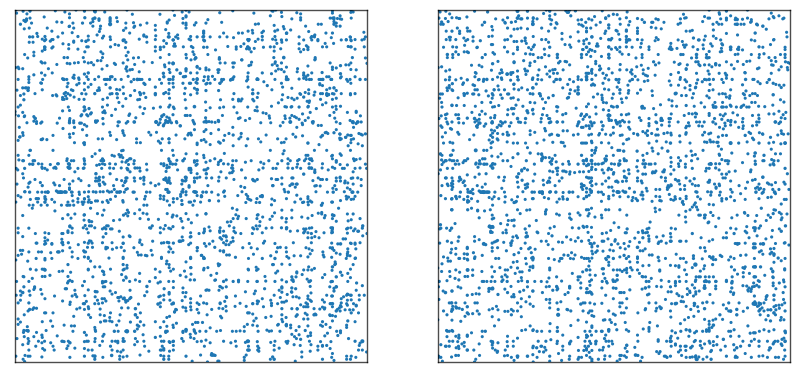

In [8]:
import seaborn as sns
from graspologic.plot import adjplot

fig, axs = plt.subplots(1,2,figsize=(10, 5))
adjplot(np_left_adj[ind_left_list[0]][:, ind_left_list[0]], plot_type='scattermap', ax=axs[0])
adjplot(np_right_adj[ind_right_list[0]][:, ind_right_list[0]], plot_type='scattermap', ax=axs[1])

Permute the skids based on graph matching, this gives us the pairs from graph matching

In [9]:
matched_pairs_list = []

for i in range(n_iters):
    left_matched_skids = left_skids[ind_left_list[i]]
    right_matched_skids = right_skids[ind_right_list[i]]

    #make dataframe for the matched pairs
    matched_pairs = pd.DataFrame(list(zip(left_matched_skids, right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    matched_pairs_list.append(matched_pairs)

Calculating the accuracy of how graph matching did (compare our pairs to Nadine's pairs)

In [10]:
accuracy_list = []
df_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    df = pd.merge(true_pairs, matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')
    df_list.append(df)
    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = df[df.duplicated("skid-ID LEFT")]
    duplicate_R = df[df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    accuracy = num/den
    accuracy_list.append(accuracy)
    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [16]:
#treat df1 as the true/nadine pairs, and the columns of df2 as the extracted left and right indexes from the left and right adjacencies
df1 = pd.DataFrame({'L': [1, 2, 4, 3, 7, 6, 5, 8], 'R': ["a", "b", "d", "c", "g", "f", "e", "h"]})
df2 = pd.DataFrame({'L': [1, 3, 12, 9, 10, 11, 2, 4, 6, 5], 'R': ["a", "d", "h", "r", "f", "u", "b", "w", "q", "c"]})
print("df1")
print(df1, "\n")
print("df2")
print(df2)

df1
   L  R
0  1  a
1  2  b
2  4  d
3  3  c
4  7  g
5  6  f
6  5  e
7  8  h 

df2
    L  R
0   1  a
1   3  d
2  12  h
3   9  r
4  10  f
5  11  u
6   2  b
7   4  w
8   6  q
9   5  c


In [17]:
#format df2 by initializing as I have done previously

#grab the neurons that are paired in df1, and both neurons in that pair exist in the L and R column of df2 respectively
L2_list = list(df2.L)
R2_list = list(df2.R)

L2_in_pair = []
R2_in_pair = []

for i in range(len(df1)):
    if(df1.loc[i, "L"] in L2_list and df1.loc[i, "R"] in R2_list):
        L2_in_pair.append(df1.loc[i, "L"])
        R2_in_pair.append(df1.loc[i, "R"])

print(L2_in_pair)
print(R2_in_pair)

[1, 2, 4, 3, 6]
['a', 'b', 'd', 'c', 'f']


In [18]:
from numpy.random import default_rng
rng = default_rng()

#grab the rest of the neurons in the L and R column of df2, and shuffle them
L2_not_in_pair = np.array([val for val in L2_list if val not in L2_in_pair])
R2_not_in_pair = np.array([val for val in R2_list if val not in R2_in_pair])


#shuffle the lists
rand_ind_left = rng.choice(len(L2_not_in_pair), size=len(L2_not_in_pair), replace=False)
L2_not_in_pair_rand = L2_not_in_pair[rand_ind_left]

rand_ind_right = rng.choice(len(R2_not_in_pair), size=len(R2_not_in_pair), replace=False)
R2_not_in_pair_rand = R2_not_in_pair[rand_ind_right]

print(L2_not_in_pair_rand)
print(R2_not_in_pair_rand)

[10  5 12 11  9]
['u' 'q' 'w' 'r' 'h']


In [19]:
#concatenate the pairs and not pairs lists

L2_to_match = np.append(L2_in_pair, L2_not_in_pair_rand, axis=0)
R2_to_match = np.append(R2_in_pair, R2_not_in_pair_rand, axis=0)

pairs = pd.DataFrame(list(zip(L2_to_match, R2_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
pairs

,skid-ID LEFT,skid-ID RIGHT
0,1,a
1,2,b
2,4,d
3,3,c
4,6,f
5,10,u
6,5,q
7,12,w
8,11,r
9,9,h


In [20]:
#simulate graph matching on these pairs, keep the second and third row intact but the others different
right_list_after_matching = ["r", "b", "c", "a", "d", "f", "w", "u", "h", "q"]

updated_pairs = pairs.copy()
updated_pairs["skid-ID RIGHT"] = right_list_after_matching
print(updated_pairs)

#should expect accuracy of 0.4

   skid-ID LEFT skid-ID RIGHT
0             1             r
1             2             b
2             4             c
3             3             a
4             6             d
5            10             f
6             5             w
7            12             u
8            11             h
9             9             q


In [21]:
#calcuate accuracy
mask = updated_pairs["skid-ID LEFT"].index < len(L2_in_pair)
L2_to_consider = updated_pairs["skid-ID LEFT"][mask]
R2_to_consider = updated_pairs["skid-ID RIGHT"][mask]

matched_pairs_test = pd.Series(index = L2_to_consider.values, data = R2_to_consider.values)

#find the R1 values that correspond to the L2_to_consider values
R1_to_consider = df1.loc[df1["L"].isin(L2_to_consider.values), "R"]

true_pairs_test = pd.Series(index = L2_to_consider.values, data = R1_to_consider.values)

print(true_pairs_test)
print(matched_pairs_test)
(matched_pairs_test == true_pairs_test).mean()

1    a
2    b
4    d
3    c
6    f
dtype: object
1    r
2    b
4    c
3    a
6    d
dtype: object


0.2

In [17]:
new_df = pd.merge(df1, df2, on=["L", 'R'], how="outer", indicator="exist")
test_num = new_df["exist"].value_counts()["both"]
duplicate_L = new_df[new_df.duplicated(['L'])]
duplicate_R = new_df[new_df.duplicated(['R'])]
new_df

,L,R,exist
0,1,a,both
1,2,b,both
2,3,c,left_only
3,4,d,left_only
4,7,g,left_only
5,6,f,left_only
6,5,e,left_only
7,8,h,left_only
8,3,d,right_only
9,12,h,right_only


In [18]:
print(duplicate_L)
print(duplicate_R)
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["L", "R"], how="outer", indicator="Exist")
acc = test_num / (test_num + len(duplicate_df))
print(acc)
duplicate_df

    L  R       exist
8   3  d  right_only
13  4  w  right_only
14  6  q  right_only
15  5  c  right_only
     L  R       exist
8    3  d  right_only
9   12  h  right_only
11  10  f  right_only
15   5  c  right_only
0.25


,L,R,exist_x,exist_y,Exist
0,3,d,right_only,right_only,both
1,4,w,right_only,NaN,left_only
2,6,q,right_only,NaN,left_only
3,5,c,right_only,right_only,both
4,12,h,NaN,right_only,right_only
5,10,f,NaN,right_only,right_only


Calculate the norm of the difference of the two adjacencies after permuting the skids

In [19]:
diff_matched_norm_list = []
for i in range(n_iters):
    #norms of matched adjs
    #subset and permute the adjacencies by their indices from matching
    np_left_adj_matched = np_left_adj[np.ix_(ind_left_list[i], ind_left_list[i])]
    np_right_adj_matched = np_right_adj[np.ix_(ind_right_list[i], ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_diff_adj_matched = np_left_adj_matched - np_right_adj_matched
    diff_matched_norm = np.linalg.norm(np_diff_adj_matched)
    diff_matched_norm_list.append(diff_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_matched_norm}")

In [20]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_left_adj), size=len(np_right_adj), replace=False)
    np_left_adj_rand = np_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_right_adj), size=len(np_right_adj), replace=False)
    np_right_adj_rand = np_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_diff_adj_rand = np_left_adj_rand - np_right_adj_rand
    diff_rand_norm = np.linalg.norm(np_diff_adj_rand)
    rand_norms_whole.append(diff_rand_norm)


In [21]:
accuracy_mean = np.average(accuracy_list)
norm_mean = np.average(diff_matched_norm_list)

Plot histogram showing how our norm compares to the norms after random permutations of the matrices

Text(0.5, 1.0, 'Norm of difference of matched vs random whole adjacencies (norm: 159.54), (accuracy: 0.01)')

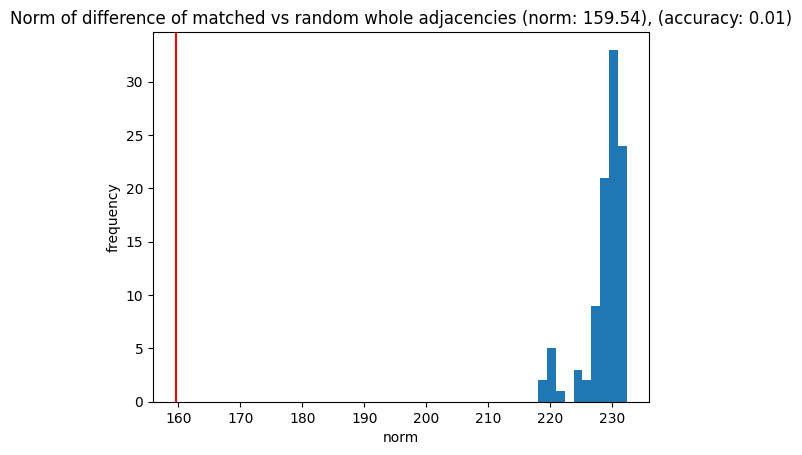

In [22]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole)
ax.axvline(norm_mean, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(norm_mean, accuracy_mean))

Look at morphologies of neurons that were paired correctly, 5 morphologies of neurons that were paired correctly in only Nadine's, and 5 morphologies of neurons that were paired in ours

In [23]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [24]:
#look at correct morphologies
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list_both = []
neuron_list_nadine = []
neuron_list_ours = []

for ind, row in df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]

    #when the pair exists in both our list and Nadine's list
    if(row["Exist"] == "both"):
        neuron_list_both.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in Nadine's list only
    elif(row["Exist"] == "left_only" and len(neuron_list_nadine)<=5):
        neuron_list_nadine.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in our list only
    elif(row["Exist"] == "right_only" and len(neuron_list_ours)<=5):
        neuron_list_ours.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

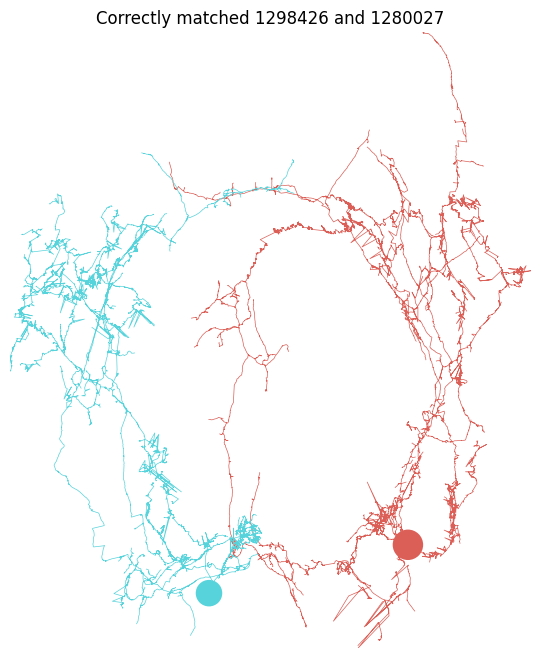

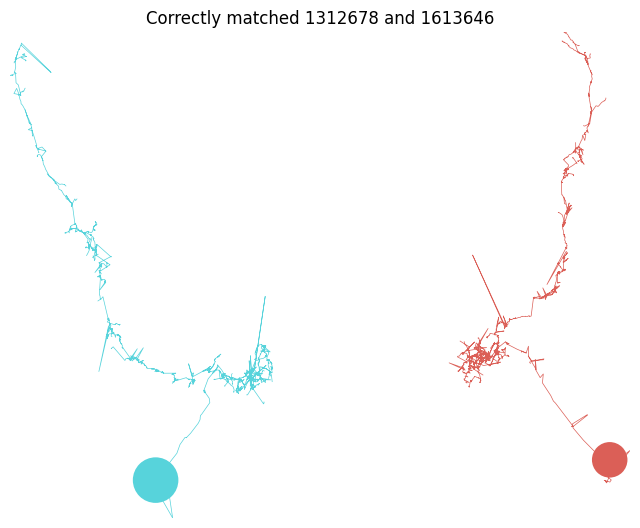

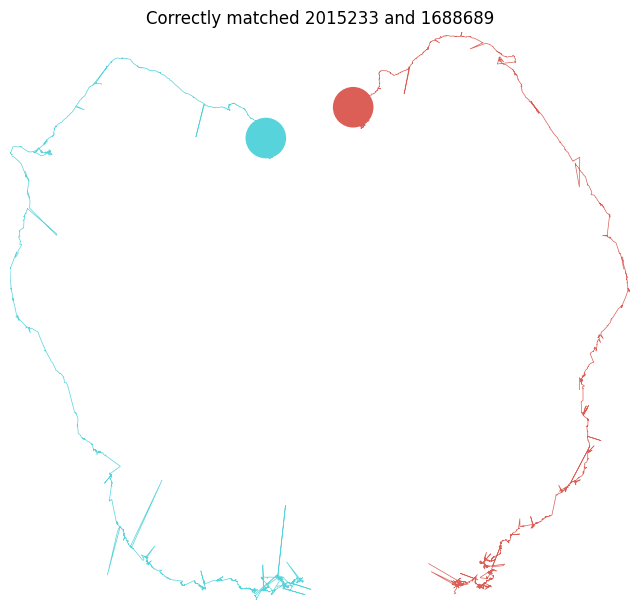

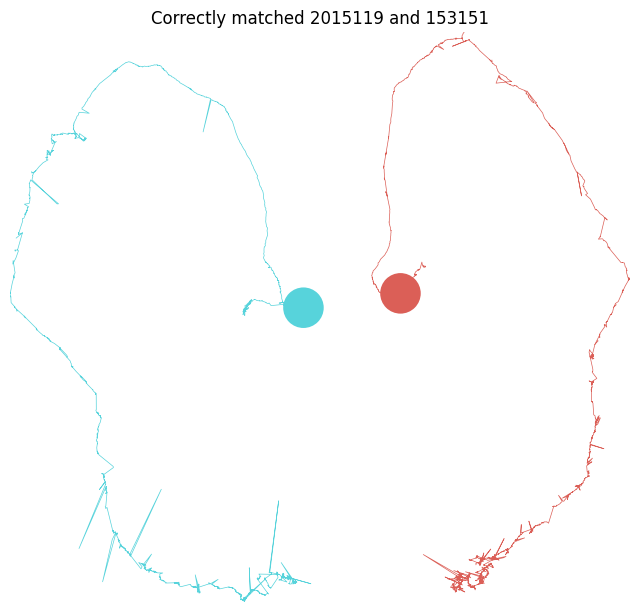

In [25]:
#visualize correctly matched neurons
for i in range(len(neuron_list_both)):
    fig, ax = navis.plot2d(neuron_list_both[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_both[i][1]
    right = neuron_list_both[i][2]
    ax.set_title(f"Correctly matched {left} and {right}")

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

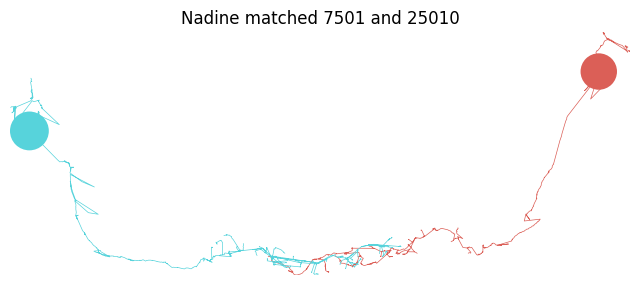

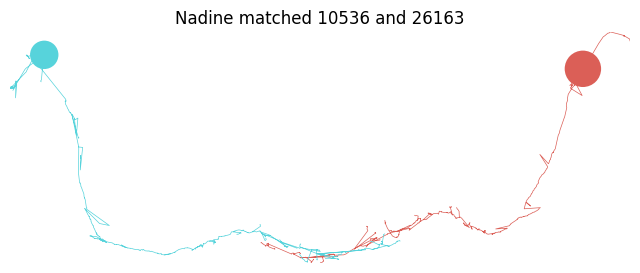

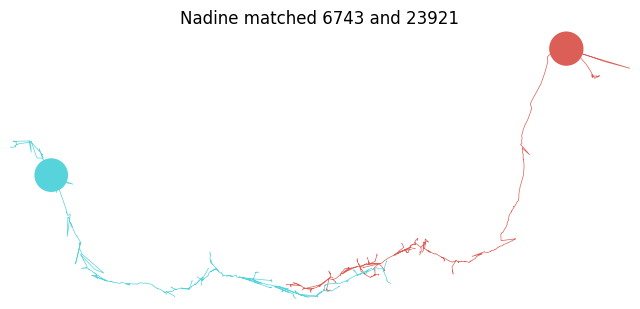

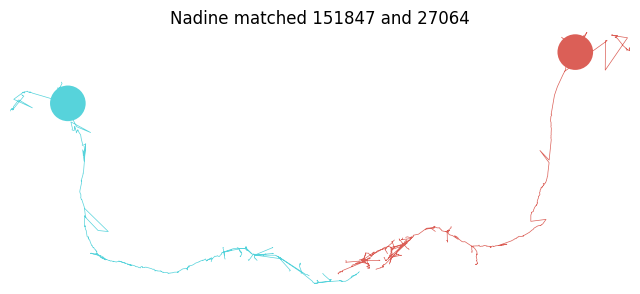

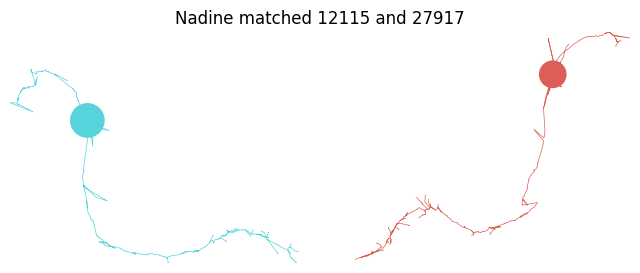

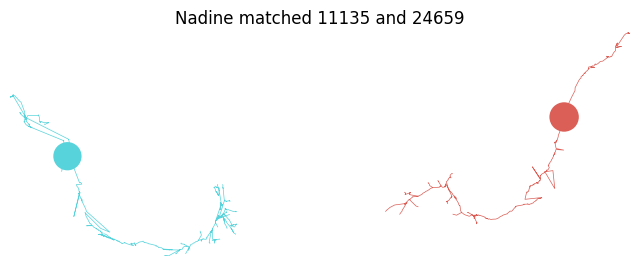

In [26]:
#visualize neurons that nadines matched that was not in ours
for i in range(len(neuron_list_nadine)):
    fig, ax = navis.plot2d(neuron_list_nadine[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_nadine[i][1]
    right = neuron_list_nadine[i][2]
    ax.set_title(f"Nadine matched {left} and {right}")

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

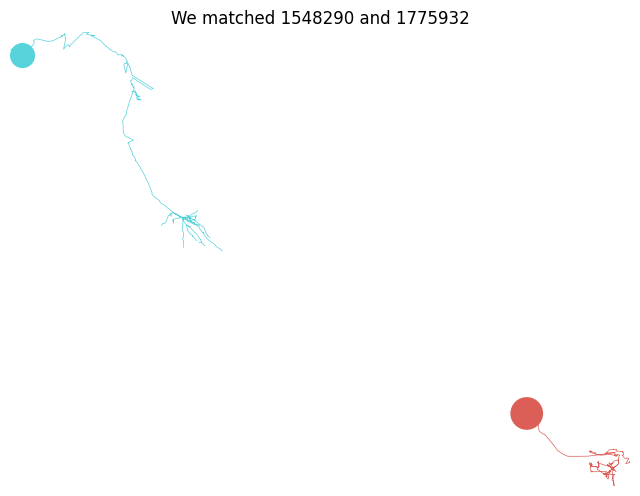

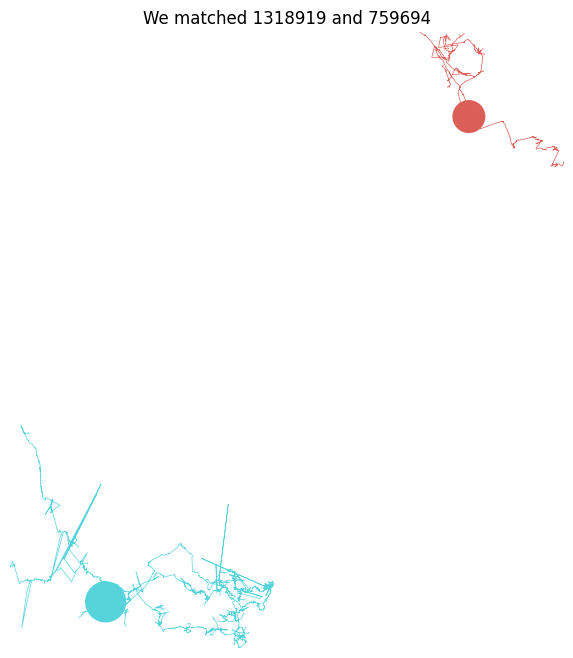

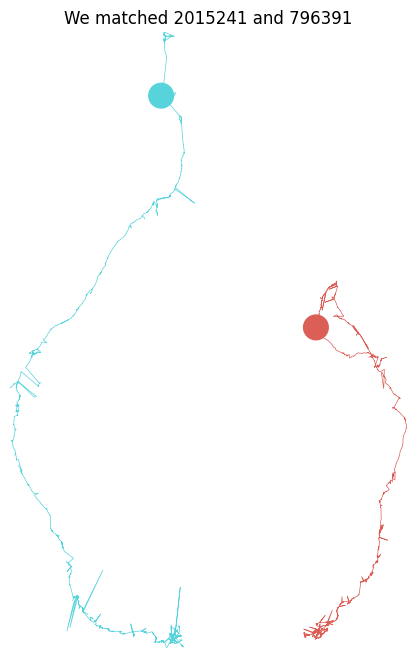

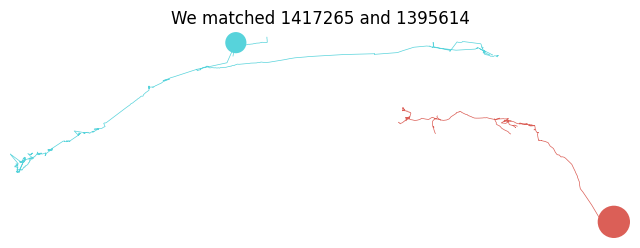

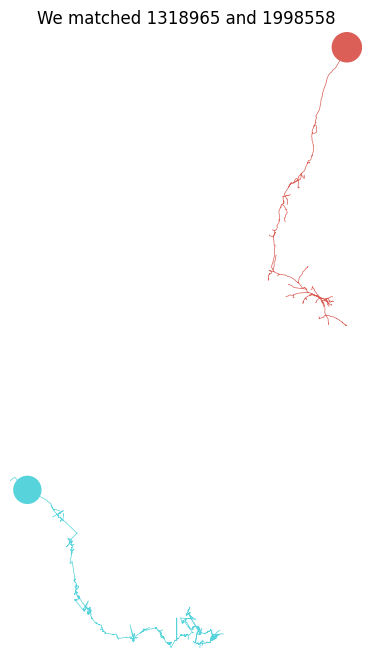

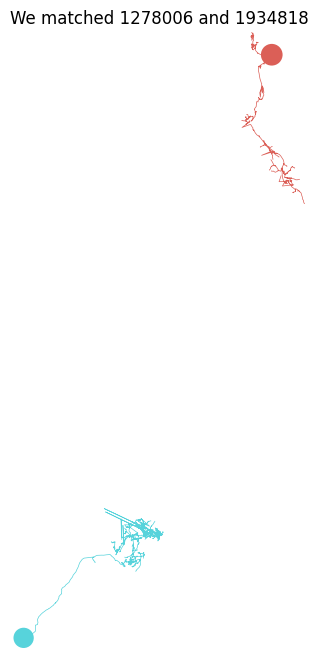

In [27]:
#visualize neurons that we matched that nadine did not
for i in range(len(neuron_list_ours)):
    fig, ax = navis.plot2d(neuron_list_ours[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_ours[i][1]
    right = neuron_list_ours[i][2]
    ax.set_title(f"We matched {left} and {right}")

Look at what happens if we initialize a permutation matrix such that the left and right adjs match Nadine's pairs

In [28]:
#first move all the left skids that are in Nadine's list to the front of the left skids list
left_skids_copy = np.array(left_skids)

#find left indices that correspond to Nadine's list
inds_nadine = [list(np.where(left_skids_copy == j)[0]) for j in left_true]

#modify inds_nadine to get rid of all empty lists (skids that exist in Nadine's skid list but not ours) and make list elements as ints
inds_nadine_filt = [ele[0] for ele in inds_nadine if ele != []]
inds_nadine_filt = np.array(inds_nadine_filt)

#save the elements that correspond (and not) to inds_nadine_filt in left_skids_copy
skids_left_nadine = left_skids_copy[inds_nadine_filt]
skids_left_not_nadine = [skid for skid in left_skids_copy if skid not in skids_left_nadine]
skids_left_not_nadine = np.array(skids_left_not_nadine)

#now concatenate the nadine skids and not_nadine left skids
skids_left_form = np.append(skids_left_nadine, skids_left_not_nadine, axis=0)

#now permute the right index list such that the pairs align with Nadine's
right_skids_copy = np.array(right_skids)

#go through the first entires of left_skids_copy and find the right_skid that corresponds to it in true_pairs
for i in range(len(inds_nadine_filt)):

    #find the index where the current left skid appears in true pairs
    ind_pair = true_pairs.loc[true_pairs["skid-ID LEFT"] == skids_left_form[i]].index[0]

    #find the right skid that corresponds to the left_skid in true pairs
    right_skid = true_pairs.loc[ind_pair, "skid-ID RIGHT"]

    #find where this right_skid is in our right_skids list, if it is not there then continue
    if right_skid not in right_skids_copy:
        continue
    
    else:
        
        #swap right_skid with the skid where it needs to go
        ind_right_curr = np.where(right_skids_copy == right_skid)[0][0]
        temp = right_skids_copy[i]
        right_skids_copy[i] = right_skid
        right_skids_copy[ind_right_curr] = temp
        
skids_right_form = right_skids_copy.copy()
whole_nadine_nadine_pairs = pd.DataFrame(list(zip(skids_left_form, skids_right_form)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

In [29]:
whole_nadine_nadine_pairs

,skid-ID LEFT,skid-ID RIGHT
0,7501,25010
1,10536,26163
2,6743,23921
3,151847,27064
4,12115,27917
...,...,...
914,1629613,608173
915,1310144,1621996
916,1670599,1441775
917,1424853,1597423


Calculate the accuracy of our permuted left and right skids do (without running graph matchingf)

In [30]:
#Accuracy of WHOLE, NADINE, NADINE

#merge the true pairs and our matched pairs by their union
whole_nadine_df = pd.merge(true_pairs, whole_nadine_nadine_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = whole_nadine_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = whole_nadine_df[whole_nadine_df.duplicated("skid-ID LEFT")]
duplicate_R = whole_nadine_df[whole_nadine_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num
accuracy_whole_nadine_nadine = num/den
print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9205776173285198


Calculate the norms of the left and right adjs after permuting the skids (no graph matching)

In [31]:
#norms of whole nadine init adjs

#chop the last skids of the left skid list so the dimensions match
skids_left_form_trunc = skids_left_form[0:len(skids_right_form)]

#make adjs
whole_nadine_left_adj = pymaid.adjacency_matrix(skids_left_form)
whole_nadine_left_adj_trunc = pymaid.adjacency_matrix(skids_left_form_trunc)
whole_nadine_right_adj = pymaid.adjacency_matrix(skids_right_form)

np_whole_nadine_left_adj = np.array(whole_nadine_left_adj)
np_whole_nadine_left_adj_trunc = np.array(whole_nadine_left_adj_trunc)
np_whole_nadine_right_adj = np.array(whole_nadine_right_adj)

#calculate norm of difference of matched adjacencies
np_diff_whole_nadine = np_whole_nadine_left_adj_trunc - np_whole_nadine_right_adj
diff_whole_nadine_norm = np.linalg.norm(np_diff_whole_nadine)

print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_norm}")

Norm of difference of left and right matched adjs: 204.9024157983502


In [32]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_nadine_left_adj_trunc), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_nadine_left_adj_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_nadine_right_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of initialized vs random whole adjacencies (norm: 204.90), (accuracy: 0.92)')

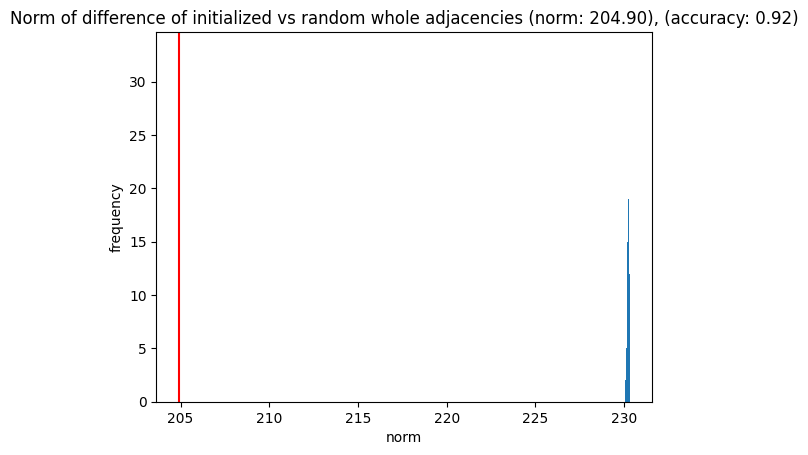

In [33]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_nadine_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_nadine_norm, accuracy_whole_nadine_nadine))

Run graph matching on our permuted adjs

In [34]:
whole_nadine_ind_left_list = []
whole_nadine_ind_right_list = []

In [35]:
#WHOLE, NADINE, OPT
for i in range(n_iters):
    whole_nadine_ind_left, whole_nadine_ind_right, score, _ = graph_match(np_whole_nadine_left_adj, np_whole_nadine_right_adj)
    whole_nadine_ind_left_list.append(whole_nadine_ind_left)
    whole_nadine_ind_right_list.append(whole_nadine_ind_right)

In [36]:
#score from WHOLE NADINE OPT
score

15192.0

In [37]:
whole_nadine_matched_pairs_list = []
for i in range(n_iters):
    skids_left_form_matched = skids_left_form[whole_nadine_ind_left_list[i]]
    skids_right_form_matched = skids_right_form[whole_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs = pd.DataFrame(list(zip(skids_left_form_matched, skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_list.append(whole_nadine_matched_pairs)

Calculate the accuracy after running graph matching on our permuted adjs

In [38]:
#WHOLE, NADINE, OPT
whole_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_df = pd.merge(true_pairs, whole_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    accuracy = num/den
    whole_nadine_matched_accuracy_list.append(accuracy)
    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

Calculate norm from running graph matching on our permuted adjs

In [39]:
#norms of whole nadine init opt adjs
whole_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_left_adj = np_whole_nadine_left_adj[np.ix_(whole_nadine_ind_left_list[i], whole_nadine_ind_left_list[i])]
    np_whole_nadine_matched_right_adj = np_whole_nadine_right_adj[np.ix_(whole_nadine_ind_right_list[i], whole_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_diff = np_whole_nadine_matched_left_adj - np_whole_nadine_matched_right_adj
    diff_whole_nadine_matched_norm = np.linalg.norm(np_whole_nadine_matched_diff)
    whole_nadine_matched_norm_list.append(diff_whole_nadine_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_norm}")

In [40]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_nadine_left_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_nadine_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_nadine_right_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [41]:
whole_nadine_matched_norm_average = np.average(whole_nadine_matched_norm_list)
whole_nadine_matched_accuracy_average = np.average(whole_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random whole adjacencies (norm: 158.98), (accuracy: 0.01)')

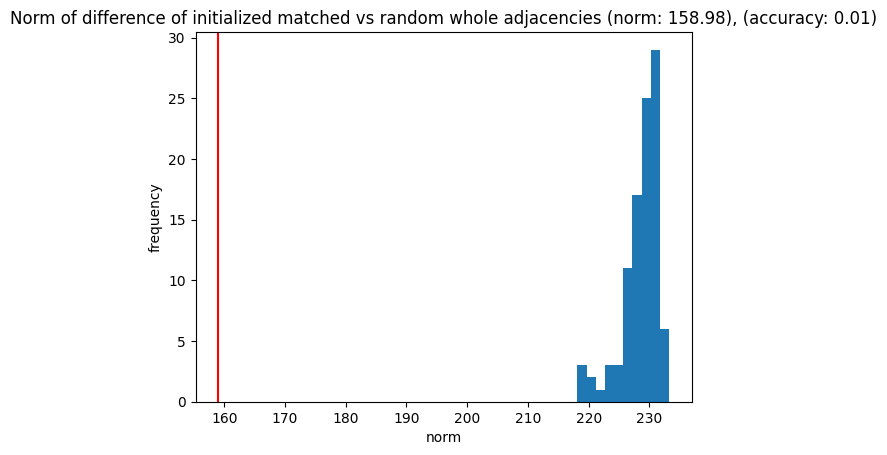

In [42]:
#histogram of WHOLE NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))

Do all the same analyses, but run on the subgraph (from our total list of left and right neurons, use the subsets of the neurons that exist in true pairs)

In [43]:
sub_left_skids = [skid for skid in left_skids if skid in left_true]
sub_right_skids = [skid for skid in right_skids if skid in right_true]

pd_sub_left_skids = pd.Series(sub_left_skids)
pd_sub_right_skids = pd.Series(sub_right_skids)

print(len(sub_left_skids))
print(len(sub_right_skids))

272
260


In [44]:
#get the sub labels for class similarity purposes

#find the inds from left and right skid lists that are in the respective subgraphs
left_inds = [i for i, e in enumerate(left_skids) if e in sub_left_skids]
right_inds = [i for i, e in enumerate(right_skids) if e in sub_right_skids]

#np_left_labels = np.array(left_labels)
#np_right_labels = np.array(right_labels)

#grab the subset of labels from the ind lists
sub_left_labels = np_left_labels[left_inds]
sub_right_labels = np_left_labels[right_inds]

In [45]:
sub_left_adj = pymaid.adjacency_matrix(sub_left_skids)
sub_right_adj = pymaid.adjacency_matrix(sub_right_skids)

np_sub_left_adj = np.array(sub_left_adj)
np_sub_right_adj = np.array(sub_right_adj)

In [46]:
sub_ind_left_list = []
sub_ind_right_list = []

Run graph matching without any initialization

In [47]:
#SUB, DEFAULT, OPT
for i in range(n_iters):
    sub_ind_left, sub_ind_right, sub_score, sub_misc = graph_match(np_sub_left_adj, np_sub_right_adj)
    sub_ind_left_list.append(sub_ind_left)
    sub_ind_right_list.append(sub_ind_right)

In [48]:
#Score from SUB, DEFAULT, OPT
sub_score

5298.0

Permute our lists of skids based on the results of graph matching

In [49]:
sub_matched_pairs_list = []
for i in range(n_iters):
    sub_left_matched_skids = pd_sub_left_skids[sub_ind_left_list[i]]
    sub_right_matched_skids = pd_sub_right_skids[sub_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_matched_pairs = pd.DataFrame(list(zip(sub_left_matched_skids, sub_right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_matched_pairs_list.append(sub_matched_pairs)

Calculate the accuracy on our subgraphs after graph matching without initialization

In [50]:
sub_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_df = pd.merge(true_pairs, sub_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    sub_num = sub_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_df[sub_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_df[sub_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    sub_den = len(duplicate_df) + sub_num
    accuracy = sub_num/sub_den
    sub_matched_accuracy_list.append(accuracy)

    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(sub_num/sub_den))

Collect the neurons that were correctly matched from graph matching

In [51]:
correct_sub_df = sub_df.loc[sub_df["Exist"] == "both"]
correct_sub_df = correct_sub_df.reset_index()
correct_sub_df

,level_0,index,skid-ID LEFT,skid-ID RIGHT,Exist
0,21,21.0,252853,252137,both
1,49,69.0,1075718,1077309,both
2,72,127.0,1333529,1333311,both
3,77,160.0,386671,161743,both
4,78,161.0,1298426,1280027,both
5,84,168.0,1295517,715837,both
6,86,170.0,1408867,1293484,both
7,93,203.0,1391222,1387435,both
8,95,205.0,1729648,1307524,both
9,98,219.0,2008640,1837982,both


Visualize the correctly matched neurons

In [52]:
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list = []
for ind, row in correct_sub_df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]
    neuron_list.append(pymaid.get_neuron(neurons))

neuron_list

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

[<class 'pymaid.core.CatmaidNeuronList'> containing 2 neurons (145.0KiB)
             type     name skeleton_id  n_nodes  n_connectors  n_branches  \
 0  CatmaidNeuron  cPRC_l2      252853     2524            88         137   
 1  CatmaidNeuron  cPRC_r2      252137     1969            74          93   
 
    n_leafs  cable_length      soma        units  
 0      164  521405.15625  [252901]  1 nanometer  
 1       97  322183.46875  [248997]  1 nanometer  ,
 <class 'pymaid.core.CatmaidNeuronList'> containing 2 neurons (98.0KiB)
             type                    name skeleton_id  n_nodes  n_connectors  \
 0  CatmaidNeuron  SNPDF-dc_l1_DLSO1.1_4l     1075718     1420            16   
 1  CatmaidNeuron  SNPDF-dc_r1_DLSO1.1_4r     1077309     1681            17   
 
    n_branches  n_leafs  cable_length       soma        units  
 0          59       62   283754.3125  [1089674]  1 nanometer  
 1          71       79   341822.4375  [1078803]  1 nanometer  ,
 <class 'pymaid.core.CatmaidNeuro

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/kareefullah/Library/Caches/pypoetry/virtualenvs/platy-data-EVeqgmAk-py3.9/lib/python3.9/site-packages/navis/plotting/dd.py:372: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=kwargs.get('figsize', (8, 8)))


Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

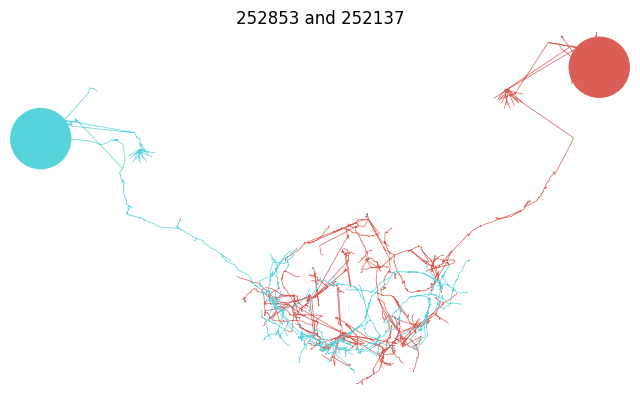

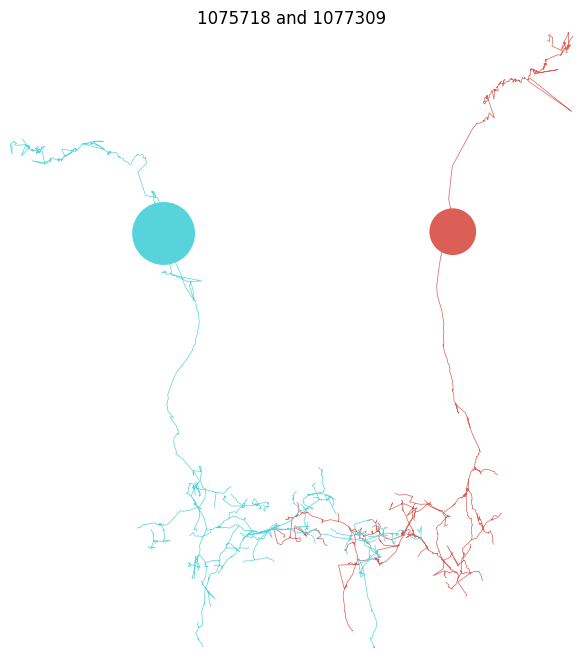

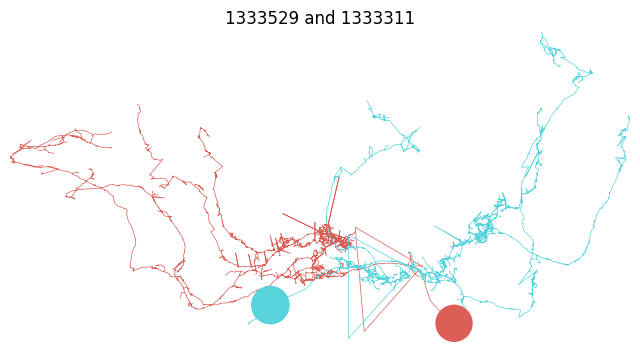

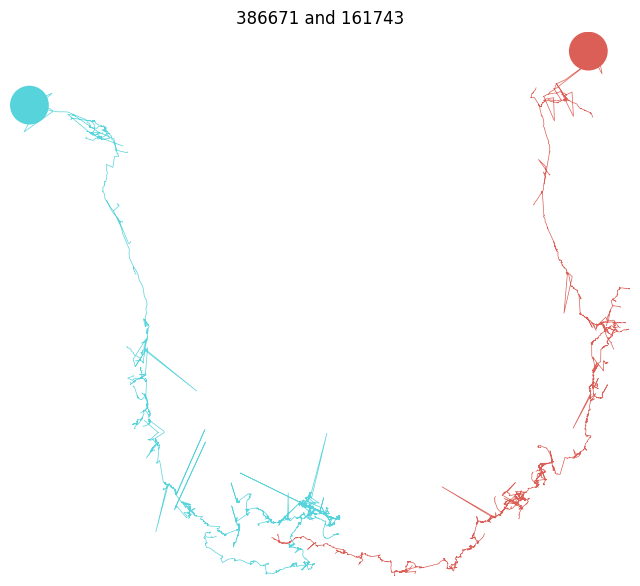

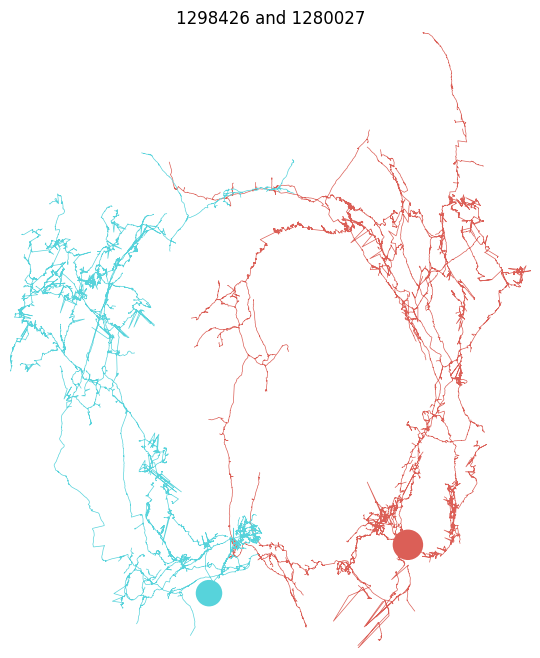

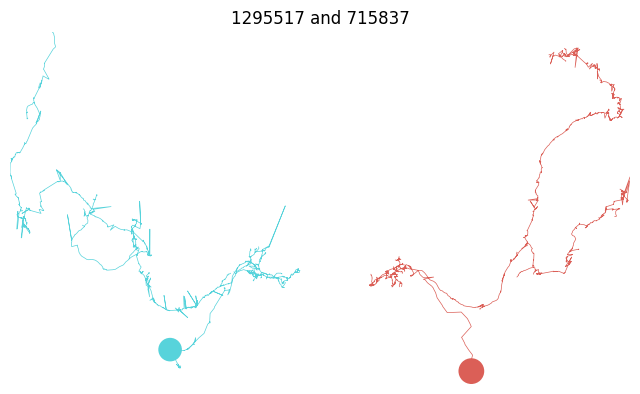

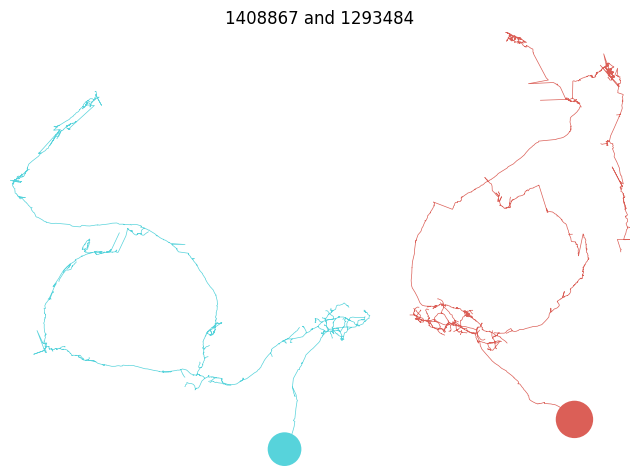

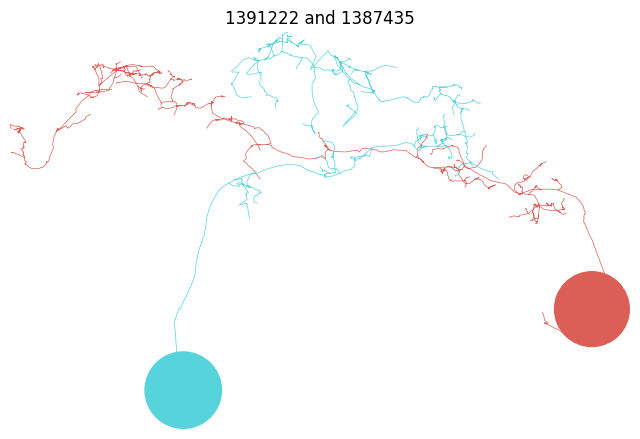

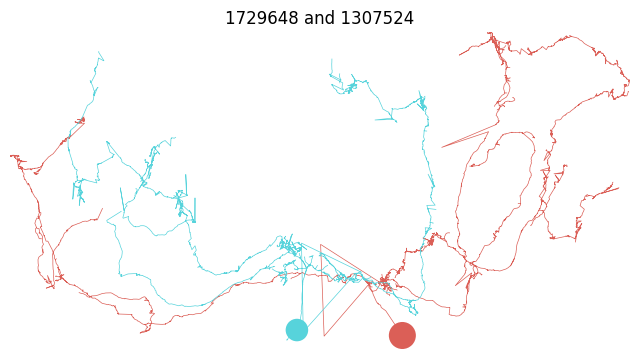

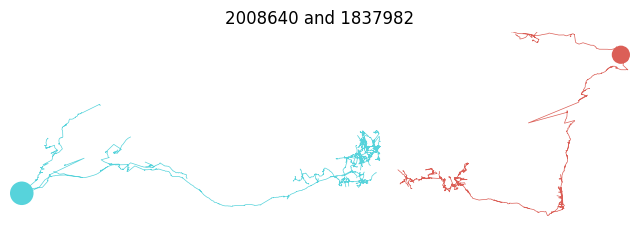

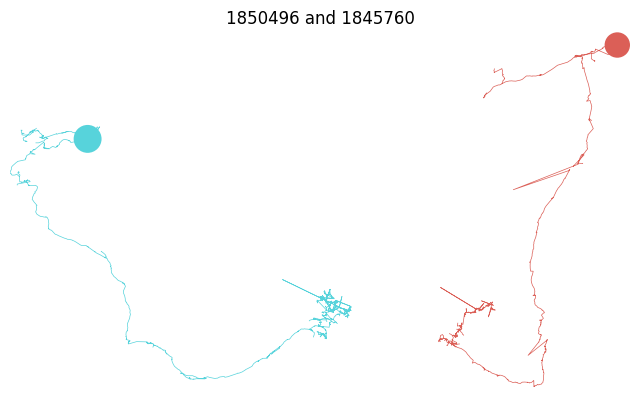

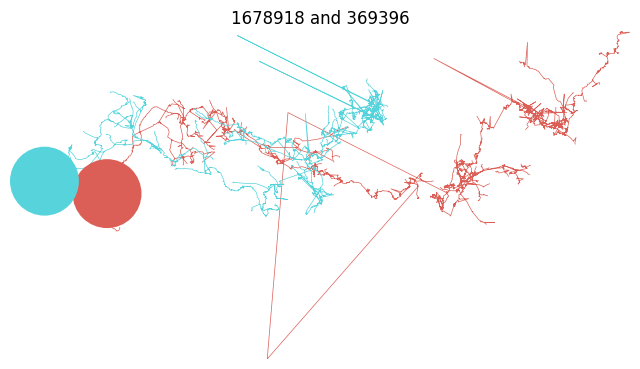

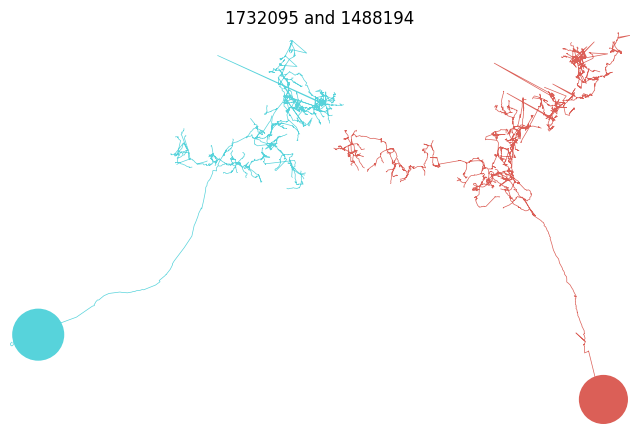

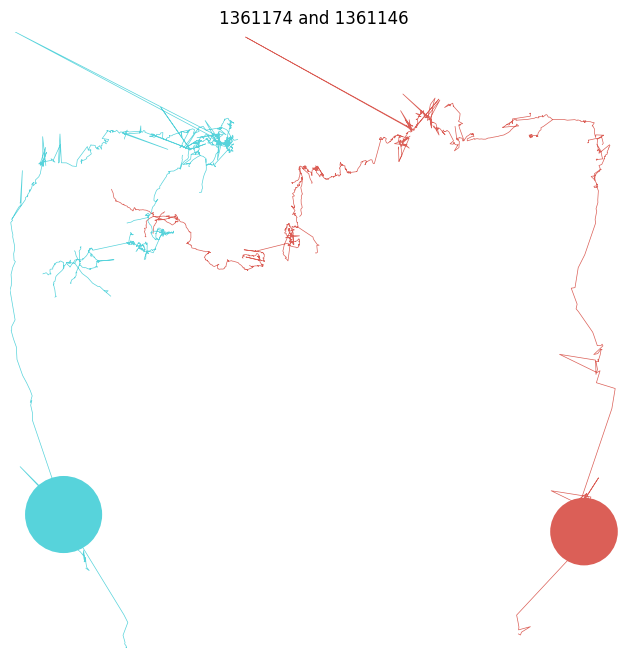

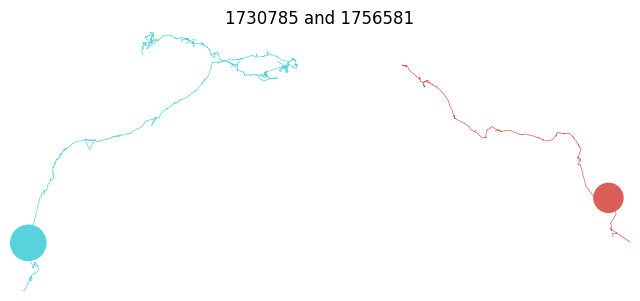

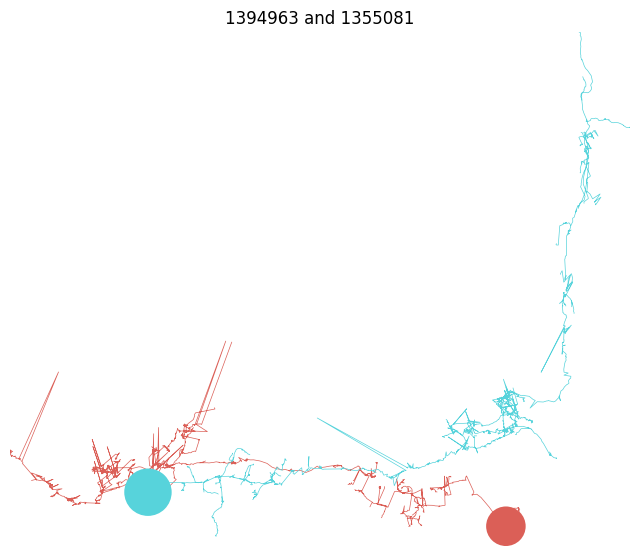

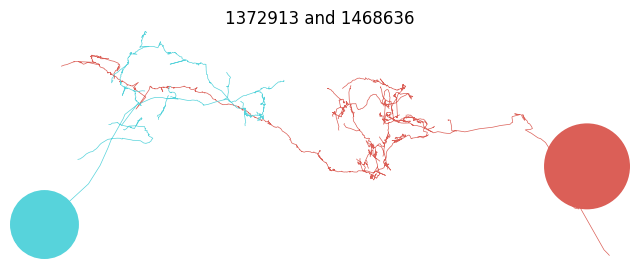

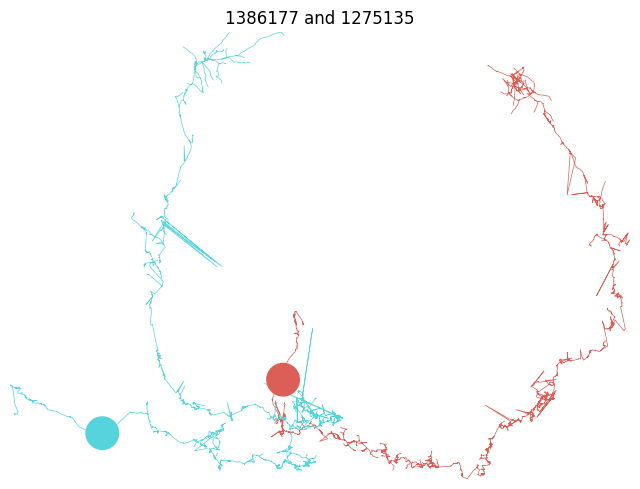

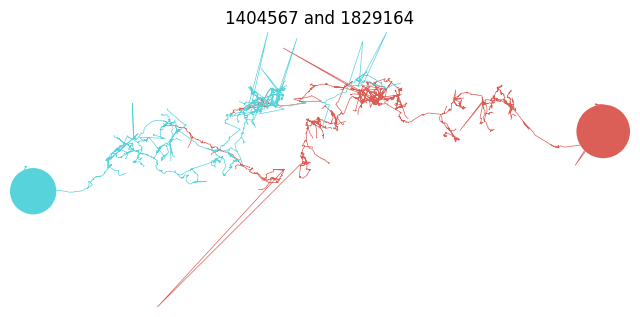

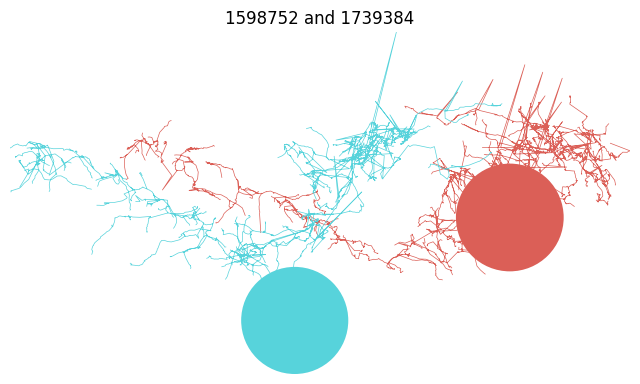

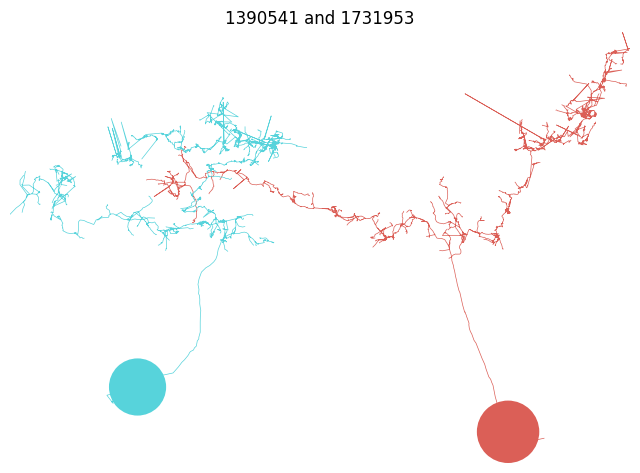

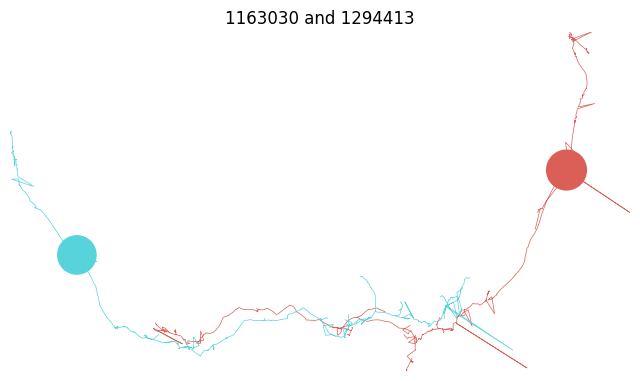

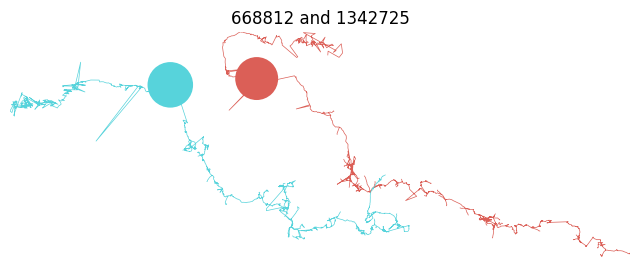

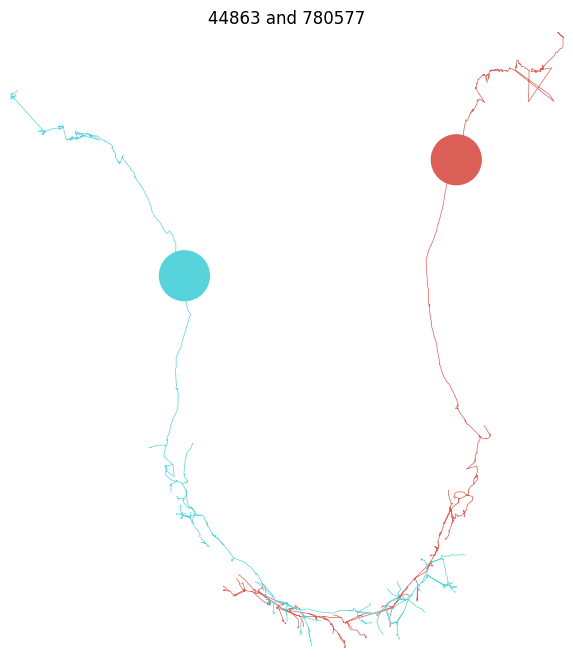

In [53]:
for i in range(len(neuron_list)):
    fig, ax = navis.plot2d(neuron_list[i], method='2d', view=('x', '-y'))
    left = correct_sub_df.loc[i, "skid-ID LEFT"]
    right = correct_sub_df.loc[i, "skid-ID RIGHT"]
    ax.set_title(f"{left} and {right}")

Take the norm of our subgraphs from graph matching

In [54]:
#norms of matched adjs
#subset and permute the adjacencies by their indices from matching
sub_matched_norm_list = []
for i in range(n_iters):
    np_sub_left_adj_matched = np_sub_left_adj[np.ix_(sub_ind_left_list[i], sub_ind_left_list[i])]
    np_sub_right_adj_matched = np_sub_right_adj[np.ix_(sub_ind_right_list[i], sub_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_diff_adj_matched = np_sub_left_adj_matched - np_sub_right_adj_matched
    sub_diff_matched_norm = np.linalg.norm(np_sub_diff_adj_matched)
    sub_matched_norm_list.append(sub_diff_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {sub_diff_matched_norm}")

In [55]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_left_adj_rand = np_sub_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_right_adj_rand = np_sub_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_diff_adj_rand = np_sub_left_adj_rand - np_sub_right_adj_rand
    sub_diff_rand_norm = np.linalg.norm(np_sub_diff_adj_rand)
    rand_norms.append(sub_diff_rand_norm)

#print(f"Norm of difference of left and right randomly permuted adjs: {sub_diff_rand_norm}")

In [56]:
sub_matched_norm_average = np.average(sub_matched_norm_list)
sub_matched_accuracy_average = np.average(sub_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of matched vs random sub adjacencies (norm: 77.60), (accuracy: 0.07)')

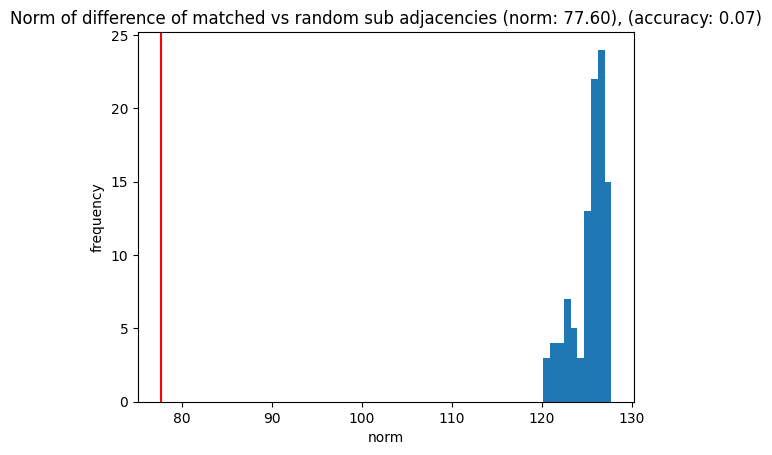

In [57]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms)
ax.axvline(sub_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average))

Look at what happens if we initialize a permutation matrix such that the left and right adjs match Nadine's pairs

In [58]:
#first move all the right skids that are in Nadine's list to the front of the right skids list
#note: doing right skids instead of left skids first because will go out of bounds when starting with left skids
sub_right_skids_copy = np.array(sub_right_skids)

#find right indices that correspond to Nadine's list
sub_inds_nadine = [list(np.where(sub_right_skids_copy == j)[0]) for j in right_true]

#modify inds_nadine to get rid of all empty lists and make list elements as ints
sub_inds_nadine_filt = [ele[0] for ele in sub_inds_nadine if ele != []]
sub_inds_nadine_filt = np.array(sub_inds_nadine_filt)

#save the elements that correspond (and not) to inds_nadine_filt in sub_right_skids_copy
sub_skids_right_nadine = sub_right_skids_copy[sub_inds_nadine_filt]
sub_skids_right_not_nadine = [skid for skid in sub_right_skids_copy if skid not in sub_skids_right_nadine]
sub_skids_right_not_nadine = np.array(sub_skids_right_not_nadine)

#now concatenate the nadine skids and not_nadine right skids
sub_skids_right_form = np.append(sub_skids_right_nadine, sub_skids_right_not_nadine, axis=0)

#now permute the left index list such that the pairs align with Nadine's
sub_left_skids_copy = np.array(sub_left_skids)

#go through the first entries of right_skids_copy and find the left_skid that corresponds to it in true_pairs
for i in range(len(sub_inds_nadine_filt)):
    
    #get the left skid which exists in nadine's pairs
    right_skid = sub_skids_right_form[i]

    #find the left skid that corresponds to the left_skid in true_pair
    sub_ind_pair = true_pairs.loc[true_pairs["skid-ID RIGHT"] == sub_skids_right_form[i]].index[0]
    left_skid = true_pairs.loc[sub_ind_pair, "skid-ID LEFT"]

    #find where this left_skid is in the left_skids list, if it is not there then continue
    if left_skid not in sub_left_skids_copy:
        continue
    
    else:
        #swap left_skid with the skid where it needs to go
        ind_left_curr = np.where(sub_left_skids_copy == left_skid)[0][0]
        temp = sub_left_skids_copy[i]
        sub_left_skids_copy[i] = left_skid
        sub_left_skids_copy[ind_left_curr] = temp
        
sub_skids_left_form = sub_left_skids_copy.copy()
sub_nadine_nadine_pairs = pd.DataFrame(list(zip(sub_skids_left_form, sub_skids_right_form)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

Calculate the accuracy on our subgraphs after initialization without graph matching

In [59]:
#Accuracy for SUB, NADINE, NADINE

#merge the true pairs and our matched pairs by their union
sub_nadine_df = pd.merge(true_pairs, sub_nadine_nadine_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = sub_nadine_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = sub_nadine_df[sub_nadine_df.duplicated("skid-ID LEFT")]
duplicate_R = sub_nadine_df[sub_nadine_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num
diff_sub_nadine_accuracy = num/den
print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))


The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307


Calculate the norm of our subgraphs after initialization without graph matching

In [60]:
#norms of whole nadine init adjs

#chop the last skids of the left skid list so the dimensions match
sub_skids_left_form_trunc = sub_skids_left_form[0:len(sub_skids_right_form)]

#make adjs
sub_nadine_left_adj = pymaid.adjacency_matrix(sub_skids_left_form)
sub_nadine_left_adj_trunc = pymaid.adjacency_matrix(sub_skids_left_form_trunc)
sub_nadine_right_adj = pymaid.adjacency_matrix(sub_skids_right_form)

np_sub_nadine_left_adj = np.array(sub_nadine_left_adj)
np_sub_nadine_left_adj_trunc = np.array(sub_nadine_left_adj_trunc)
np_sub_nadine_right_adj = np.array(sub_nadine_right_adj)

#calculate norm of difference of matched adjacencies
np_diff_sub_nadine = np_sub_nadine_left_adj_trunc - np_sub_nadine_right_adj
diff_sub_nadine_norm = np.linalg.norm(np_diff_sub_nadine)

print(f"Norm of difference of left and right subgraph Nadine initialized adjs: {diff_sub_nadine_norm}")

Norm of difference of left and right subgraph Nadine initialized adjs: 77.0454411370329


In [61]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_nadine_left_adj_trunc), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_nadine_left_adj_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_nadine_right_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of initialized vs random sub adjacencies (norm: 77.05), (accuracy: 0.98)')

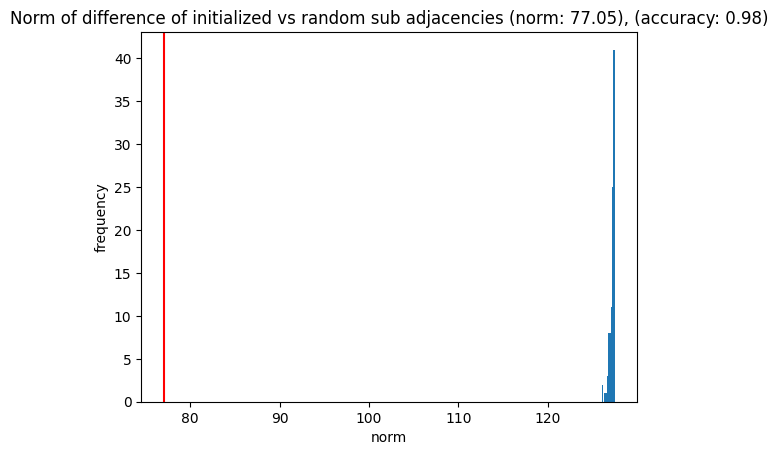

In [62]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_nadine_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_nadine_norm, diff_sub_nadine_accuracy))

Run graph matching on our subgraphs after initialization

In [63]:
sub_nadine_ind_left_list = []
sub_nadine_ind_right_list = []

In [64]:
#SUB, NADINE, OPT
for i in range(n_iters):
    sub_nadine_ind_left, sub_nadine_ind_right, sub_score_align, _ = graph_match(np_sub_nadine_left_adj, np_sub_nadine_right_adj)
    sub_nadine_ind_left_list.append(sub_nadine_ind_left)
    sub_nadine_ind_right_list.append(sub_nadine_ind_right)

In [65]:
#SUB, NADINE, OPT
sub_score_align

5239.0

In [66]:
sub_nadine_matched_pairs_list = []
for i in range(n_iters):
    sub_skids_left_form_matched = sub_skids_left_form[sub_nadine_ind_left_list[i]]
    sub_skids_right_form_matched = sub_skids_right_form[sub_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs = pd.DataFrame(list(zip(sub_skids_left_form_matched, sub_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_list.append(sub_nadine_matched_pairs)

Accuracy on our subgraphs after initialization and graph matching

In [67]:
#SUB, NADINE, OPT
sub_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_df = pd.merge(true_pairs, sub_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_accuracy = num/den
    sub_nadine_matched_accuracy_list.append(sub_nadine_accuracy)

    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.03076923076923077
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.06153846153846154
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.06153846153846154
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.07692307692307693
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.07692307692307693
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.06153846153846154
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.06923076923076923
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.06923076923076923
The proportion of left right pairs from graph ma

Calculate norm of our subgraphs after initialization and graph matching

In [68]:
#norms of sub nadine init opt adjs
sub_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_left_adj = np_sub_nadine_left_adj[np.ix_(sub_nadine_ind_left_list[i], sub_nadine_ind_left_list[i])]
    np_sub_nadine_matched_right_adj = np_sub_nadine_right_adj[np.ix_(sub_nadine_ind_right_list[i], sub_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_diff = np_sub_nadine_matched_left_adj - np_sub_nadine_matched_right_adj
    diff_sub_nadine_matched_norm = np.linalg.norm(np_sub_nadine_matched_diff)
    sub_nadine_matched_norm_list.append(diff_sub_nadine_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_norm}")

In [69]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_nadine_left_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_sub_nadine_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_nadine_right_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [70]:
sub_nadine_matched_norm_average = np.average(sub_nadine_matched_norm_list)
sub_nadine_matched_accuracy_average = np.average(sub_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random sub adjacencies (norm: 77.30), (accuracy: 0.06)')

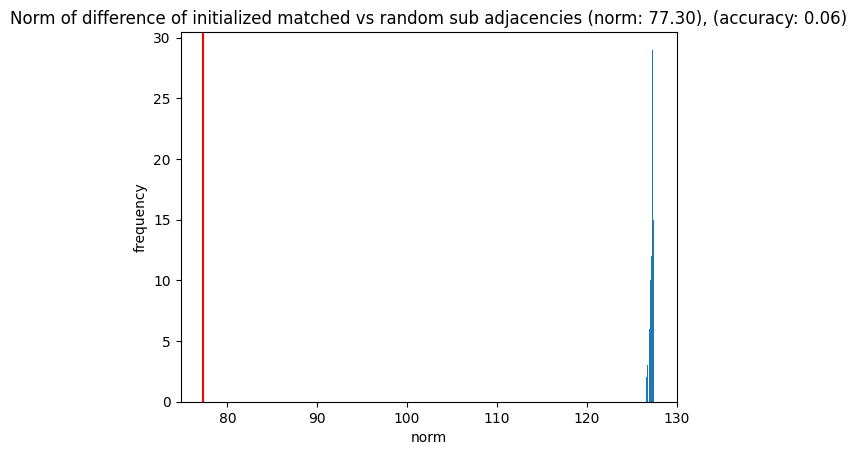

In [71]:
#histogram of SUB NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))

In [72]:
from numpy.random import default_rng

rng = default_rng()
numbers = rng.choice(20, size=10, replace=False)
numbers

array([18,  7, 16,  8, 12,  6,  9,  4, 15,  0])

In [73]:
x = np.linspace(0, 1, 3)
y = np.linspace(0, 1, 2)
xv, yv = np.meshgrid(x, y)
xv

array([[0. , 0.5, 1. ],
       [0. , 0.5, 1. ]])

In [74]:
n1 = np.arange(5)
n2 = np.arange(4)
a = np.arange(100)
a.shape = (10,10)
a[np.ix_(n1, n2)]

array([[ 0,  1,  2,  3],
       [10, 11, 12, 13],
       [20, 21, 22, 23],
       [30, 31, 32, 33],
       [40, 41, 42, 43]])

We will construct a permutation matrix P such that PBP^T causes correspondance to Nadine's pairs for both the subgraphs and the whole graphs

- Let's say we are at row i in our left subgraph, and obviously since this is a subgraph of the Nadine paired neurons, the skid of this row is going to be in the left true list since it has been matched by Nadine
    - If we go through the whole adjs, then if the left neuron is not in the true_pairs, then continue to next row in left graph
- Need to go through true_pairs to find the right neuron that our current left neuron corresponds to, and need to find the row where this neuron is in the right subgraph
    - In this row put a 1 in position i and a 0 everywhere else in the row
    - Keep track of the i's in which we fill the corresponding rows out
    - If we go through the right graph and the right neuron that we found earlier is not a skid in the right graph, then continue to next row in left graph
- In the rows of the right graph we did not examine put a 1 in a random spot that does not correspond to an i and 0's elsewhere
    - Keep track of each spot where the 1 was added in these random rows, cannot add a 1 in a differnt row in that same spot
- After constructing permutation matrix P, then do PBP^T, then do next steps



Optimization methods

- Nadine's pairs: make permutation matrix to correspond to Nadine's pairs in previous step and calculate accuracy and norm (can't do for default because need permutation matrix) (both subgraph and whole) (?)
- Opt: run graph matching and calculate accuracy and norm (for both default and Nadine permutation) (both subgraph and whole) see if score from graph matching with default initialization is worse than if initializing with permutation matrix
- Random: do random permutations of the rows of the right graph and calculate accuracy and norm (for both default and Nadine permutation) (both subgraph and whole)
- Focus on whole adjs

- Look at graph matching for the whole left and right graphs and compute accuracy and norm histogram (make sure to subset Nadine's true pairs correctly) (ensure accuracy is calculated correctly: look at picture of board to see how that is done)
- Show morphologies for 10 of the pairs that we matched that are not in Nadine's and 10 of the pairs that Nadine matched that are not in ours 
- Calculate norms for several situations (Nadine's subgraphs vs whole graphs, default init vs Nadine init (make permutation matrix such that PBP^T causes correspondance to Nadine's pairs (can verify with Pedigo after making)) optimization method (use nadine's pairs straightup on the subgraph, graph matching, random))
- (Note: when constructing permutation matrix to correspond to Nadine's pairs when using the entire whole graphs, can use random entries for the rows that do not correspond to Nadine's pairs (refer to "up" on graph: rows for permutation matrix there will be random))

- Make Gantt Chart timeline for what I need to get done
- Make permutation matrix by extracting the left and right skids and then rearranging the right skids such that it matches Nadine's pairs and then make adjacency matrix for right by reindexing, then the permutation matrix would be identity
- Get accuracies and norms for default and Nadine init with diff optimization methods (focus on Nadine's pairs and whole adjs), look at score from graph matching with default and see if worse than if initializing with permutation matrix 

- Go through Nadine's pairs, and find the pairs where the left neuron exists in our left skids and the right neurons exists in our right skids
    - L1: list of left neurons here, R1: list of right neurons here
- Go through our left and right skids, collect the skids that are not in L1 and R1, call these lists L2 and R2
- Shuffle L2 and R2
- L3 = L1 + L2, R3 = R1 + R2
- Extract adjacencies using these lists of skids using pymaid
- Run graph matching on adjacencies using an init parameter which will be an identity matrix the size of the larger of the two matrices
- Calculate norm and accuracy from graph matching

Do the initialization on the whole graph

In [75]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
whole_left_skids_in_pairs = []
whole_right_skids_in_pairs = []

#iterate through Nadine's list
for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids):
        whole_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        whole_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [76]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
whole_left_skids_not_pairs = np.array([skid for skid in left_skids if skid not in whole_left_skids_in_pairs])
whole_right_skids_not_pairs = np.array([skid for skid in right_skids if skid not in whole_right_skids_in_pairs])

whole_left_skids_not_pairs_rand_list = []
whole_right_skids_not_pairs_rand_list = []

#shuffle the lists n_iters times
for i in range(n_iters):
    rand_ind_left = rng.choice(len(whole_left_skids_not_pairs), size=len(whole_left_skids_not_pairs), replace=False)
    whole_left_skids_not_pairs_rand = whole_left_skids_not_pairs[rand_ind_left]
    whole_left_skids_not_pairs_rand_list.append(whole_left_skids_not_pairs_rand)

    rand_ind_right = rng.choice(len(whole_right_skids_not_pairs), size=len(whole_right_skids_not_pairs), replace=False)
    whole_right_skids_not_pairs_rand = whole_right_skids_not_pairs[rand_ind_right]
    whole_right_skids_not_pairs_rand_list.append(whole_right_skids_not_pairs_rand)

In [77]:
#concatenate the pairs and not pairs lists
whole_left_skids_to_match_list = []
whole_right_skids_to_match_list = []
whole_nadine_pairs_list = []

for i in range(n_iters):
    whole_left_skids_to_match = np.append(whole_left_skids_in_pairs, whole_left_skids_not_pairs_rand_list[i], axis=0)
    whole_left_skids_to_match_list.append(whole_left_skids_to_match)

    whole_right_skids_to_match = np.append(whole_right_skids_in_pairs, whole_right_skids_not_pairs_rand_list[i], axis=0)
    whole_right_skids_to_match_list.append(whole_right_skids_to_match)

    #Some of the last skids of the left list are removed so that the dimensions match in the dataframe
    whole_nadine_pairs = pd.DataFrame(list(zip(whole_left_skids_to_match, whole_right_skids_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_pairs_list.append(whole_nadine_pairs)

Calculate the norm and accuracy of the initialized skids before graph matching

In [78]:
#WHOLE, NADINE, NADINE
whole_to_match_accuracy_list = []

for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_df = pd.merge(true_pairs, whole_nadine_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_df[whole_nadine_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_df[whole_nadine_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_to_match_accuracy = num/den
    whole_to_match_accuracy_list.append(whole_to_match_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9205776173285198
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9272727272727272
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9205776173285198
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9205776173285198
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9205776173285198
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching t

In [79]:
#norms of whole nadine init adjs
diff_whole_to_match_norm_list = []

for i in range(n_iters):
    #chop the last skids of the left skid list so the dimensions match
    whole_left_skids_to_match_trunc = whole_left_skids_to_match_list[i][0:len(whole_right_skids_to_match_list[i])]

    #make adjs from skids
    whole_left_adj_to_match = pymaid.adjacency_matrix(whole_left_skids_to_match_list[i])
    whole_left_adj_to_match_trunc = pymaid.adjacency_matrix(whole_left_skids_to_match_trunc)
    whole_right_adj_to_match = pymaid.adjacency_matrix(whole_right_skids_to_match_list[i])

    #convert adjs to numpy
    np_whole_left_adj_to_match = np.array(whole_left_adj_to_match)
    np_whole_left_adj_to_match_trunc = np.array(whole_left_adj_to_match_trunc)
    np_whole_right_adj_to_match = np.array(whole_right_adj_to_match)

    #calculate norm of difference of matched adjacencies
    np_diff_whole_nadine = np_whole_left_adj_to_match_trunc - np_whole_right_adj_to_match
    diff_whole_to_match_norm = np.linalg.norm(np_diff_whole_nadine)
    diff_whole_to_match_norm_list.append(diff_whole_to_match_norm)

    print(f"Norm of difference of left and right matched adjs: {diff_whole_to_match_norm}")

Norm of difference of left and right matched adjs: 205.5966925804012
Norm of difference of left and right matched adjs: 204.24250292238392
Norm of difference of left and right matched adjs: 207.63429389192913
Norm of difference of left and right matched adjs: 197.4968354176846
Norm of difference of left and right matched adjs: 205.01219475923864
Norm of difference of left and right matched adjs: 196.10966319893572
Norm of difference of left and right matched adjs: 206.6760750546613
Norm of difference of left and right matched adjs: 207.65114976806655
Norm of difference of left and right matched adjs: 207.53553912523031
Norm of difference of left and right matched adjs: 206.45580640902304


In [81]:
whole_nadine_pairs

,skid-ID LEFT,skid-ID RIGHT
0,7501,25010
1,10536,26163
2,6743,23921
3,151847,27064
4,12115,27917
...,...,...
914,1155295,1279584
915,1435324,1377483
916,1278598,1028395
917,2010225,580213


In [82]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):

    #randomly subset the truncated left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match_trunc), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [83]:
diff_whole_to_match_norm_average = np.average(diff_whole_to_match_norm_list)
whole_to_match_accuracy_average = np.average(whole_to_match_accuracy)

Text(0.5, 1.0, 'Norm of difference of initialized vs random whole adjacencies (norm: 204.44), (accuracy: 0.92)')

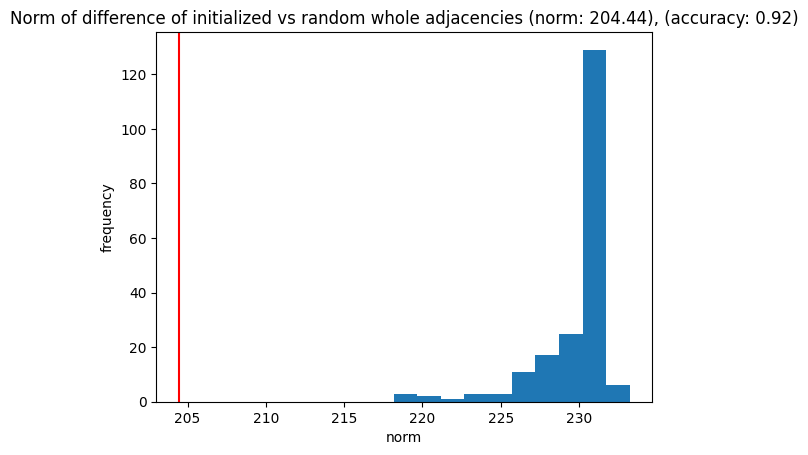

In [84]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_to_match_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average))

In [85]:
whole_nadine_ind_left_list = []
whole_nadine_ind_right_list = []
n_iters = 10
#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
perm_mat = np.eye(max(len(whole_left_skids_to_match), len(whole_right_skids_to_match)))

In [86]:
#graph match with initialization on whole graph
for i in range(n_iters):
    whole_nadine_ind_left, whole_nadine_ind_right, whole_score_align, _ = graph_match(np_whole_left_adj_to_match, np_whole_right_adj_to_match, init=perm_mat)
    whole_nadine_ind_left_list.append(whole_nadine_ind_left)
    whole_nadine_ind_right_list.append(whole_nadine_ind_right)

In [87]:
whole_score_align

16800.0

In [88]:
whole_nadine_matched_pairs_list = []
for i in range(n_iters):
    whole_skids_left_form_matched = whole_left_skids_to_match[whole_nadine_ind_left_list[i]]
    whole_skids_right_form_matched = whole_right_skids_to_match[whole_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs = pd.DataFrame(list(zip(whole_skids_left_form_matched, whole_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_list.append(whole_nadine_matched_pairs)

In [89]:
#WHOLE, NADINE, OPT
whole_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_df = pd.merge(true_pairs, whole_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_accuracy = num/den
    whole_nadine_matched_accuracy_list.append(whole_nadine_matched_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.25668449197860965
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2684931506849315
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.27595628415300544
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2601626016260163
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.26430517711171664
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.25753424657534246
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.26216216216216215
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.26216216216216215
The proportion of left right pairs from graph matc

In [90]:
#norms of whole init opt adjs
whole_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_left_adj = np_whole_left_adj_to_match[np.ix_(whole_nadine_ind_left_list[i], whole_nadine_ind_left_list[i])]
    np_whole_nadine_matched_right_adj = np_whole_right_adj_to_match[np.ix_(whole_nadine_ind_right_list[i], whole_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_diff = np_whole_nadine_matched_left_adj - np_whole_nadine_matched_right_adj
    diff_whole_nadine_matched_norm = np.linalg.norm(np_whole_nadine_matched_diff)
    whole_nadine_matched_norm_list.append(diff_whole_nadine_matched_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 146.2805523642839
Norm of difference of left and right matched adjs: 146.21901381147393
Norm of difference of left and right matched adjs: 146.3693957082559
Norm of difference of left and right matched adjs: 145.91778507090902
Norm of difference of left and right matched adjs: 146.0719001040241
Norm of difference of left and right matched adjs: 145.90065112945865
Norm of difference of left and right matched adjs: 145.88351517563592
Norm of difference of left and right matched adjs: 145.85609346201483
Norm of difference of left and right matched adjs: 145.91778507090902
Norm of difference of left and right matched adjs: 146.11981385151023


In [91]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [92]:
whole_nadine_matched_norm_average = np.average(whole_nadine_matched_norm_list)
whole_nadine_matched_accuracy_average = np.average(whole_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random whole adjacencies (norm: 146.05), (accuracy: 0.26)')

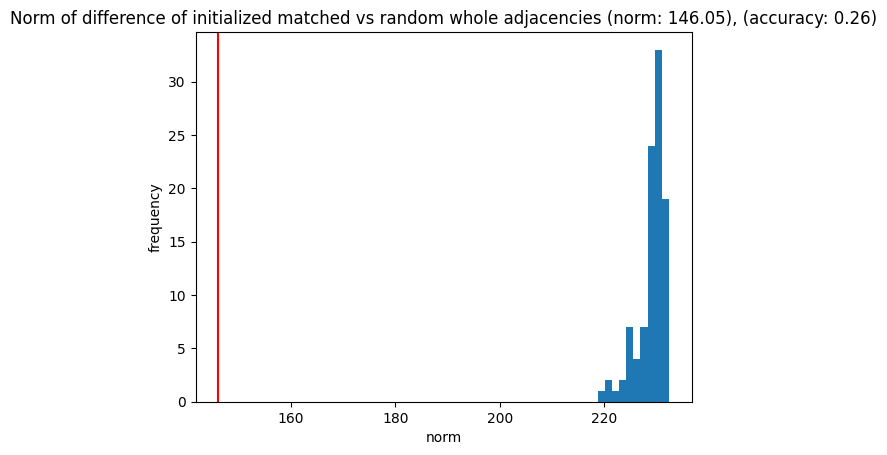

In [93]:
#histogram of WHOLE NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))

In [94]:
n_iters
perm_mat_seed = np.eye(len(np_whole_left_adj_to_match)-len(whole_left_skids_in_pairs))
len(perm_mat_seed)

712

In [95]:
#seeded graph matching
partial_match_whole = np.stack(
    (np.arange(len(whole_left_skids_in_pairs)), np.arange(len(whole_right_skids_in_pairs)))
).T

whole_nadine_ind_left_seed_list = []
whole_nadine_ind_right_seed_list = []
for i in range(n_iters):
    whole_nadine_ind_left_seed, whole_nadine_ind_right_seed, whole_score_seed, _ = graph_match(np_whole_left_adj_to_match, np_whole_right_adj_to_match, partial_match=partial_match_whole)
    whole_nadine_ind_left_seed_list.append(whole_nadine_ind_left_seed)
    whole_nadine_ind_right_seed_list.append(whole_nadine_ind_right_seed)

In [96]:
print(whole_score_seed)

15906.0


In [97]:
whole_nadine_matched_pairs_seed_list = []
for i in range(n_iters):
    whole_skids_left_form_matched_seed = whole_left_skids_to_match[whole_nadine_ind_left_seed_list[i]]
    whole_skids_right_form_matched_seed = whole_right_skids_to_match[whole_nadine_ind_right_seed_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs_seed = pd.DataFrame(list(zip(whole_skids_left_form_matched_seed, whole_skids_right_form_matched_seed)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_seed_list.append(whole_nadine_matched_pairs_seed)

In [98]:
#WHOLE, NADINE, SEED
whole_nadine_matched_seed_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_seed_df = pd.merge(true_pairs, whole_nadine_matched_pairs_seed_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_seed_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_seed_df[whole_nadine_matched_seed_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_seed_df[whole_nadine_matched_seed_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_seed_accuracy = num/den
    whole_nadine_matched_seed_accuracy_list.append(whole_nadine_matched_seed_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9272727272727272
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9306569343065694
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching t

In [99]:
#norms of whole init seed adjs
whole_nadine_matched_seed_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_seed_left_adj = np_whole_left_adj_to_match[np.ix_(whole_nadine_ind_left_seed_list[i], whole_nadine_ind_left_seed_list[i])]
    np_whole_nadine_matched_seed_right_adj = np_whole_right_adj_to_match[np.ix_(whole_nadine_ind_right_seed_list[i], whole_nadine_ind_right_seed_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_seed_diff = np_whole_nadine_matched_seed_left_adj - np_whole_nadine_matched_seed_right_adj
    diff_whole_nadine_matched_seed_norm = np.linalg.norm(np_whole_nadine_matched_seed_diff)
    whole_nadine_matched_seed_norm_list.append(diff_whole_nadine_matched_seed_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_seed_norm}")

Norm of difference of left and right matched adjs: 151.87165634179408
Norm of difference of left and right matched adjs: 151.58495967608397


Norm of difference of left and right matched adjs: 151.8519015356739
Norm of difference of left and right matched adjs: 152.18081350814234
Norm of difference of left and right matched adjs: 152.0065788049978
Norm of difference of left and right matched adjs: 152.19395520190676
Norm of difference of left and right matched adjs: 152.0986521965267
Norm of difference of left and right matched adjs: 151.65750888103102
Norm of difference of left and right matched adjs: 151.9374871452072
Norm of difference of left and right matched adjs: 151.94077793666847


In [100]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [101]:
whole_nadine_matched_seed_norm_average = np.average(whole_nadine_matched_seed_norm_list)
whole_nadine_matched_seed_accuracy_average = np.average(whole_nadine_matched_seed_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of seeded matched vs random whole adjacencies (norm: 151.93), (accuracy: 0.93)')

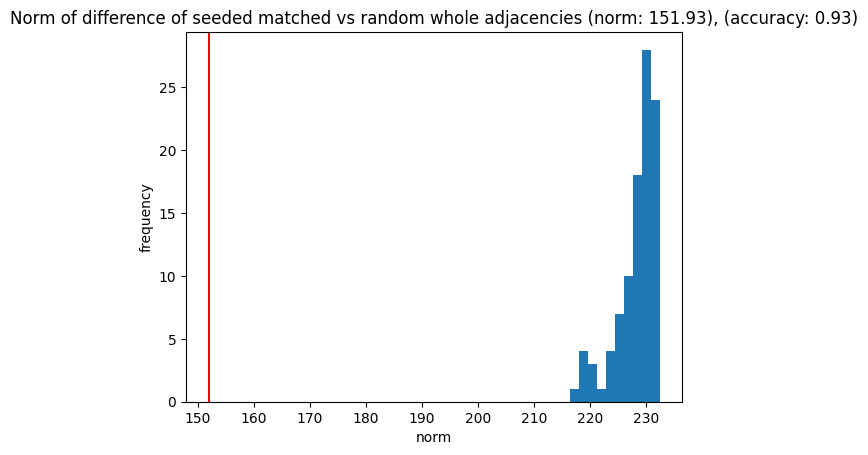

In [102]:
#histogram of WHOLE NADINE SEED
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_seed_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of seeded matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_seed_norm_average, whole_nadine_matched_seed_accuracy_average))

<AxesSubplot:>

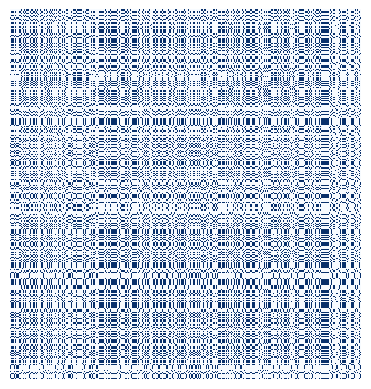

In [103]:
#whole class similarity
whole_class_similarity = (np_left_labels[:, None] == np_right_labels[None, :])

sns.heatmap(
    whole_class_similarity,
    cmap="Blues",
    cbar=False,
    square=True,
    xticklabels=False,
    yticklabels=False,
)

In [104]:
whole_nadine_ind_left_class_list = []
whole_nadine_ind_right_class_list = []
for i in range(n_iters):
    whole_nadine_ind_left_class, whole_nadine_ind_right_class, whole_score_class, _ = graph_match(np_left_adj, np_right_adj, S=whole_class_similarity, verbose=3)
    whole_nadine_ind_left_class_list.append(whole_nadine_ind_left_class)
    whole_nadine_ind_right_class_list.append(whole_nadine_ind_right_class)

[Pre-loop] Initializing
   [Pre-loop] Computing constant terms
   [Iteration: 1] Computing gradient
   [Iteration: 1] Solving assignment problem
   [Iteration: 1] Computing step size
   [Iteration: 2] Computing gradient
   [Iteration: 2] Solving assignment problem
   [Iteration: 2] Computing step size
   [Iteration: 3] Computing gradient
   [Iteration: 3] Solving assignment problem
   [Iteration: 3] Computing step size
   [Iteration: 4] Computing gradient
   [Iteration: 4] Solving assignment problem
   [Iteration: 4] Computing step size
   [Iteration: 5] Computing gradient
   [Iteration: 5] Solving assignment problem
   [Iteration: 5] Computing step size
   [Iteration: 6] Computing gradient
   [Iteration: 6] Solving assignment problem
   [Iteration: 6] Computing step size
   [Iteration: 7] Computing gradient
   [Iteration: 7] Solving assignment problem
   [Iteration: 7] Computing step size
   [Iteration: 8] Computing gradient
   [Iteration: 8] Solving assignment problem
   [Iteration: 

In [105]:
print(whole_score_class)

16827.0


In [106]:
whole_nadine_matched_pairs_class_list = []
for i in range(n_iters):
    whole_skids_left_form_matched_class = whole_left_skids_to_match[whole_nadine_ind_left_class_list[i]]
    whole_skids_right_form_matched_class = whole_right_skids_to_match[whole_nadine_ind_right_class_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs_class = pd.DataFrame(list(zip(whole_skids_left_form_matched_class, whole_skids_right_form_matched_class)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_class_list.append(whole_nadine_matched_pairs_class)

In [107]:
#WHOLE, NADINE, CLASS
whole_nadine_matched_class_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_class_df = pd.merge(true_pairs, whole_nadine_matched_pairs_class_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_class_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_class_df[whole_nadine_matched_class_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_class_df[whole_nadine_matched_class_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_class_accuracy = num/den
    whole_nadine_matched_class_accuracy_list.append(whole_nadine_matched_class_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.002232142857142857
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.002232142857142857
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0022123893805309734
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.004424778761061947
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0022727272727272726
The proportion of left right pairs from graph matching that correctly match with the true

In [108]:
#norms of whole init class adjs
whole_nadine_matched_class_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_class_left_adj = np_left_adj[np.ix_(whole_nadine_ind_left_class_list[i], whole_nadine_ind_left_class_list[i])]
    np_whole_nadine_matched_class_right_adj = np_right_adj[np.ix_(whole_nadine_ind_right_class_list[i], whole_nadine_ind_right_class_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_class_diff = np_whole_nadine_matched_class_left_adj - np_whole_nadine_matched_class_right_adj
    diff_whole_nadine_matched_class_norm = np.linalg.norm(np_whole_nadine_matched_class_diff)
    whole_nadine_matched_class_norm_list.append(diff_whole_nadine_matched_class_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_class_norm}")

Norm of difference of left and right matched adjs: 152.7154216181195
Norm of difference of left and right matched adjs: 147.97972834141845
Norm of difference of left and right matched adjs: 149.46236984605858
Norm of difference of left and right matched adjs: 148.0
Norm of difference of left and right matched adjs: 148.12157169028418
Norm of difference of left and right matched adjs: 148.16882263148344
Norm of difference of left and right matched adjs: 148.7783586413024
Norm of difference of left and right matched adjs: 148.9731519435633
Norm of difference of left and right matched adjs: 150.7812985751217
Norm of difference of left and right matched adjs: 150.42606157179014


In [109]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [110]:
whole_nadine_matched_class_norm_average = np.average(whole_nadine_matched_class_norm_list)
whole_nadine_matched_class_accuracy_average = np.average(whole_nadine_matched_class_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of matched vs random whole adjacencies with class similarity (norm: 149.34), (accuracy: 0.00)')

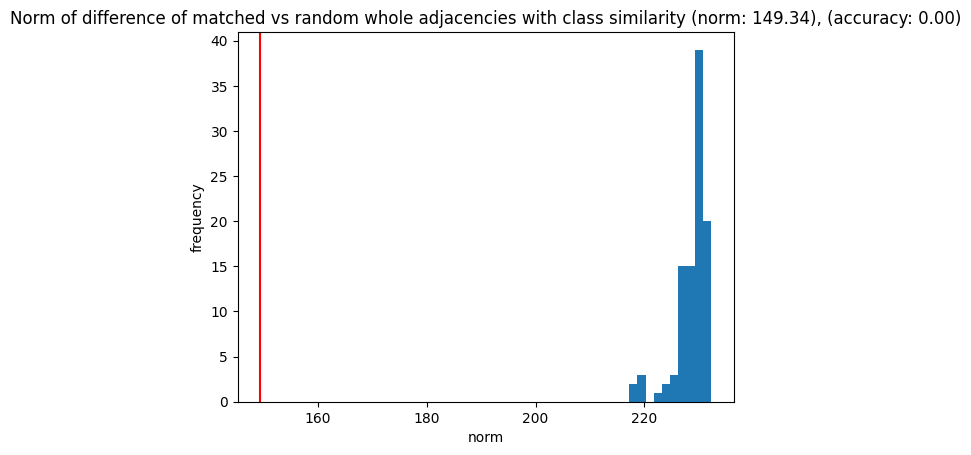

In [111]:
#histogram of WHOLE NADINE CLASS
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_class_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random whole adjacencies with class similarity (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_class_norm_average, whole_nadine_matched_class_accuracy_average))

Now we do the same initialization but on the subgraph of the left and right neurons

In [112]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
sub_left_skids_in_pairs = []
sub_right_skids_in_pairs = []

for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in sub_left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in sub_right_skids):
        sub_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        sub_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [113]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
sub_left_skids_not_pairs = np.array([skid for skid in sub_left_skids if skid not in sub_left_skids_in_pairs])
sub_right_skids_not_pairs = np.array([skid for skid in sub_right_skids if skid not in sub_right_skids_in_pairs])

sub_left_skids_not_pairs_rand_list = []
sub_right_skids_not_pairs_rand_list = []

#shuffle the lists n_iters times
for i in range(n_iters):
    rand_ind_left = rng.choice(len(sub_left_skids_not_pairs), size=len(sub_left_skids_not_pairs), replace=False)
    sub_left_skids_not_pairs_rand = sub_left_skids_not_pairs[rand_ind_left]
    sub_left_skids_not_pairs_rand_list.append(sub_left_skids_not_pairs_rand)

    rand_ind_right = rng.choice(len(sub_right_skids_not_pairs), size=len(sub_right_skids_not_pairs), replace=False)
    sub_right_skids_not_pairs_rand = sub_right_skids_not_pairs[rand_ind_right]
    sub_right_skids_not_pairs_rand_list.append(sub_right_skids_not_pairs_rand)

In [114]:
#concatenate the pairs and not pairs lists
sub_left_skids_to_match_list = []
sub_right_skids_to_match_list = []
sub_nadine_pairs_list = []

for i in range(n_iters):
    sub_left_skids_to_match = np.append(sub_left_skids_in_pairs, sub_left_skids_not_pairs_rand_list[i], axis=0)
    sub_left_skids_to_match_list.append(sub_left_skids_to_match)

    sub_right_skids_to_match = np.append(sub_right_skids_in_pairs, sub_right_skids_not_pairs_rand_list[i], axis=0)
    sub_right_skids_to_match_list.append(sub_right_skids_to_match)

    sub_nadine_pairs = pd.DataFrame(list(zip(sub_left_skids_to_match, sub_right_skids_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_pairs_list.append(sub_nadine_pairs)

In [115]:
#SUB, NADINE, NADINE
sub_to_match_accuracy_list = []

for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_df = pd.merge(true_pairs, sub_nadine_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_df[sub_nadine_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_df[sub_nadine_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_to_match_accuracy = num/den
    sub_to_match_accuracy_list.append(sub_to_match_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching t

In [116]:
#norms of sub nadine init adjs
diff_sub_to_match_norm_list = []
np_sub_left_adj_to_match_list = []
np_sub_left_adj_to_match_trunc_list = []
np_sub_right_adj_to_match_list = []

for i in range(n_iters):
    #chop the last skids of the left skid list so the dimensions match
    sub_left_skids_to_match_trunc = sub_left_skids_to_match_list[i][0:len(sub_right_skids_to_match_list[i])]

    #make adjs
    sub_left_adj_to_match = pymaid.adjacency_matrix(sub_left_skids_to_match_list[i])
    sub_left_adj_to_match_trunc = pymaid.adjacency_matrix(sub_left_skids_to_match_trunc)
    sub_right_adj_to_match = pymaid.adjacency_matrix(sub_right_skids_to_match_list[i])

    np_sub_left_adj_to_match = np.array(sub_left_adj_to_match)
    np_sub_left_adj_to_match_trunc = np.array(sub_left_adj_to_match_trunc)
    np_sub_right_adj_to_match = np.array(sub_right_adj_to_match)

    np_sub_left_adj_to_match_list.append(np_sub_left_adj_to_match)
    np_sub_left_adj_to_match_trunc_list.append(np_sub_left_adj_to_match_trunc)
    np_sub_right_adj_to_match_list.append(np_sub_right_adj_to_match)

    #calculate norm of difference of matched adjacencies
    np_diff_sub_nadine = np_sub_left_adj_to_match_trunc - np_sub_right_adj_to_match
    diff_sub_to_match_norm = np.linalg.norm(np_diff_sub_nadine)
    diff_sub_to_match_norm_list.append(diff_sub_to_match_norm)

    print(f"Norm of difference of left and right matched adjs: {diff_sub_to_match_norm}")

Norm of difference of left and right matched adjs: 77.01298591796062
Norm of difference of left and right matched adjs: 77.4919350642375
Norm of difference of left and right matched adjs: 77.06490770772389
Norm of difference of left and right matched adjs: 77.01298591796062
Norm of difference of left and right matched adjs: 77.54353615872827
Norm of difference of left and right matched adjs: 77.03895118704564
Norm of difference of left and right matched adjs: 77.09734106958553
Norm of difference of left and right matched adjs: 77.03895118704564
Norm of difference of left and right matched adjs: 77.09085548883213
Norm of difference of left and right matched adjs: 77.54353615872827


In [117]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [118]:
diff_sub_to_match_norm_average = np.average(diff_sub_to_match_norm_list)
sub_to_match_accuracy_average = np.average(sub_to_match_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized vs random sub adjacencies (norm: 77.19), (accuracy: 0.98)')

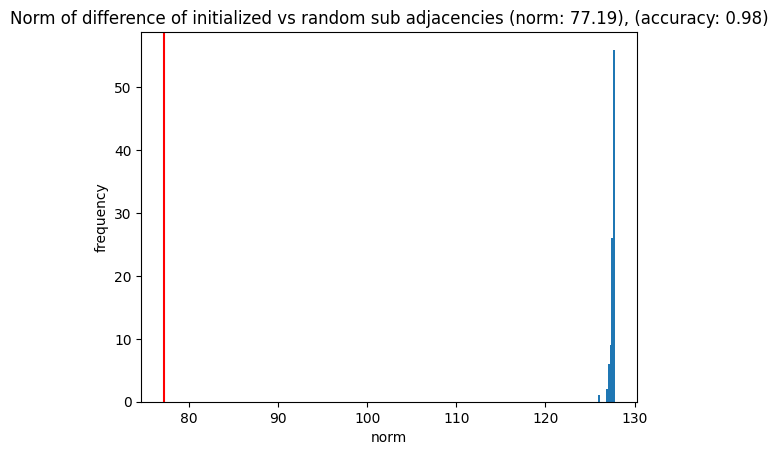

In [119]:
#histogram of SUB NADINE NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_to_match_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average))

In [120]:
sub_nadine_ind_left_list = []
sub_nadine_ind_right_list = []

#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
sub_perm_mat = np.eye(max(len(sub_left_skids_to_match), len(sub_right_skids_to_match)))

In [121]:
#graph match with initialization on subgraphs
for i in range(n_iters):
    sub_nadine_ind_left, sub_nadine_ind_right, sub_score_align, _ = graph_match(np_sub_left_adj_to_match, np_sub_right_adj_to_match, init=sub_perm_mat)
    sub_nadine_ind_left_list.append(sub_nadine_ind_left)
    sub_nadine_ind_right_list.append(sub_nadine_ind_right)

In [122]:
sub_score_align

5853.0

In [123]:
sub_nadine_matched_pairs_list = []
for i in range(n_iters):
    sub_skids_left_form_matched = sub_left_skids_to_match[sub_nadine_ind_left_list[i]]
    sub_skids_right_form_matched = sub_right_skids_to_match[sub_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs = pd.DataFrame(list(zip(sub_skids_left_form_matched, sub_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_list.append(sub_nadine_matched_pairs)

In [124]:
#SUB, NADINE, OPT
sub_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_df = pd.merge(true_pairs, sub_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_df["Exist"].value_counts()["both"]
    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_accuracy = num/den
    sub_nadine_matched_accuracy_list.append(sub_nadine_matched_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4153846153846154
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4423076923076923
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4115384615384615
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.3923076923076923
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4230769230769231
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4153846153846154
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4115384615384615
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4307692307692308
The proportion of left right pairs from graph matching t

In [125]:
#norms of sub init opt adjs
sub_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_left_adj = np_sub_left_adj_to_match[np.ix_(sub_nadine_ind_left_list[i], sub_nadine_ind_left_list[i])]
    np_sub_nadine_matched_right_adj = np_sub_right_adj_to_match[np.ix_(sub_nadine_ind_right_list[i], sub_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_diff = np_sub_nadine_matched_left_adj - np_sub_nadine_matched_right_adj
    diff_sub_nadine_matched_norm = np.linalg.norm(np_sub_nadine_matched_diff)
    sub_nadine_matched_norm_list.append(diff_sub_nadine_matched_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 68.47627326307996
Norm of difference of left and right matched adjs: 68.62215385719105
Norm of difference of left and right matched adjs: 68.28616258071617
Norm of difference of left and right matched adjs: 68.45436436049933
Norm of difference of left and right matched adjs: 68.62215385719105
Norm of difference of left and right matched adjs: 68.5054742338158
Norm of difference of left and right matched adjs: 68.49087530467106
Norm of difference of left and right matched adjs: 68.59300255857006
Norm of difference of left and right matched adjs: 68.51277253184256
Norm of difference of left and right matched adjs: 68.61486719363377


In [126]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_left_adj_to_match_rand = np_sub_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_right_adj_to_match_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_left_adj_to_match_rand - np_sub_right_adj_to_match_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [127]:
sub_nadine_matched_norm_average = np.average(sub_nadine_matched_norm_list)
sub_nadine_matched_accuracy_average = np.average(sub_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random sub adjacencies (norm: 68.52), (accuracy: 0.42)')

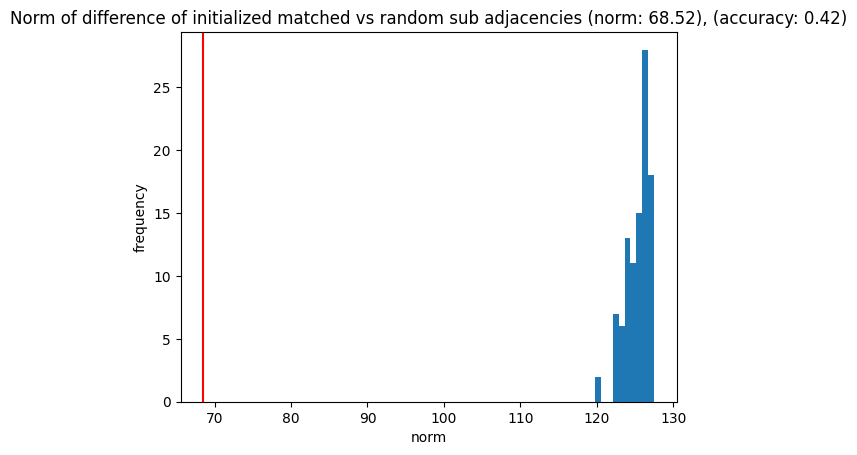

In [128]:
#histogram of SUB INIT OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))

In [129]:
#seeded graph matching
partial_match_sub = np.stack(
    (np.arange(len(sub_left_skids_in_pairs)), np.arange(len(sub_right_skids_in_pairs)))
).T

sub_nadine_ind_left_seed_list = []
sub_nadine_ind_right_seed_list = []
for i in range(n_iters):
    sub_nadine_ind_left_seed, sub_nadine_ind_right_seed, sub_score_seed, _ = graph_match(np_sub_left_adj_to_match, np_sub_right_adj_to_match, partial_match=partial_match_sub)
    sub_nadine_ind_left_seed_list.append(sub_nadine_ind_left_seed)
    sub_nadine_ind_right_seed_list.append(sub_nadine_ind_right_seed)

In [130]:
sub_score_seed

5162.0

In [131]:
sub_nadine_matched_pairs_seed_list = []
for i in range(n_iters):
    sub_skids_left_form_matched_seed = sub_left_skids_to_match[sub_nadine_ind_left_seed_list[i]]
    sub_skids_right_form_matched_seed = sub_right_skids_to_match[sub_nadine_ind_right_seed_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs_seed = pd.DataFrame(list(zip(sub_skids_left_form_matched_seed, sub_skids_right_form_matched_seed)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_seed_list.append(sub_nadine_matched_pairs_seed)

In [132]:
#SUB, NADINE, OPT
sub_nadine_matched_seed_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_seed_df = pd.merge(true_pairs, sub_nadine_matched_pairs_seed_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_seed_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_seed_df[sub_nadine_matched_seed_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_seed_df[sub_nadine_matched_seed_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_seed_accuracy = num/den
    sub_nadine_matched_seed_accuracy_list.append(sub_nadine_matched_seed_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching t

In [133]:
#norms of sub init seed adjs
sub_nadine_matched_seed_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_seed_left_adj = np_sub_left_adj_to_match[np.ix_(sub_nadine_ind_left_seed_list[i], sub_nadine_ind_left_seed_list[i])]
    np_sub_nadine_matched_seed_right_adj = np_sub_right_adj_to_match[np.ix_(sub_nadine_ind_right_seed_list[i], sub_nadine_ind_right_seed_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_seed_diff = np_sub_nadine_matched_seed_left_adj - np_sub_nadine_matched_seed_right_adj
    diff_sub_nadine_matched_seed_norm = np.linalg.norm(np_sub_nadine_matched_seed_diff)
    sub_nadine_matched_seed_norm_list.append(diff_sub_nadine_matched_seed_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_seed_norm}")

Norm of difference of left and right matched adjs: 77.54353615872827
Norm of difference of left and right matched adjs: 77.62087348130012
Norm of difference of left and right matched adjs: 77.0454411370329
Norm of difference of left and right matched adjs: 77.53708789992051
Norm of difference of left and right matched adjs: 77.54353615872827
Norm of difference of left and right matched adjs: 77.57576941287789
Norm of difference of left and right matched adjs: 77.1621668954417
Norm of difference of left and right matched adjs: 77.57576941287789
Norm of difference of left and right matched adjs: 77.46612162745726
Norm of difference of left and right matched adjs: 77.1686464828819


In [134]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [135]:
sub_nadine_matched_seed_norm_average = np.average(sub_nadine_matched_seed_norm_list)
sub_nadine_matched_seed_accuracy_average = np.average(sub_nadine_matched_seed_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of seeded matched vs random sub adjacencies (norm: 77.42), (accuracy: 0.98)')

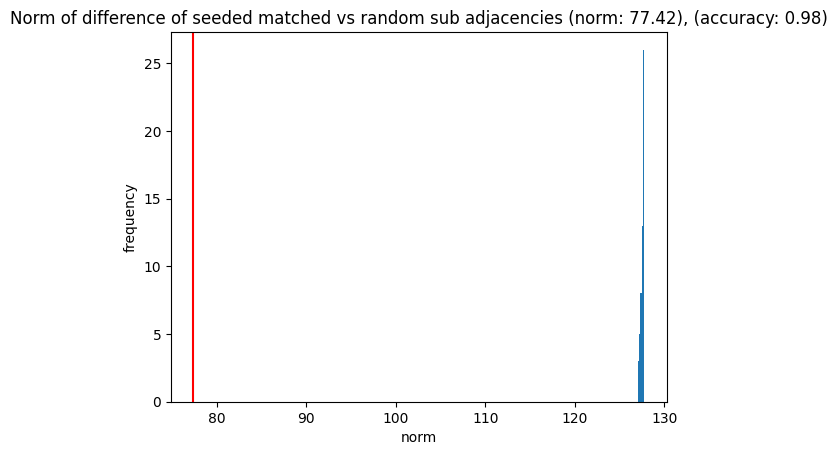

In [136]:
#histogram of SUB NADINE SEED
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_seed_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of seeded matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_seed_norm_average, sub_nadine_matched_seed_accuracy_average))

<AxesSubplot:>

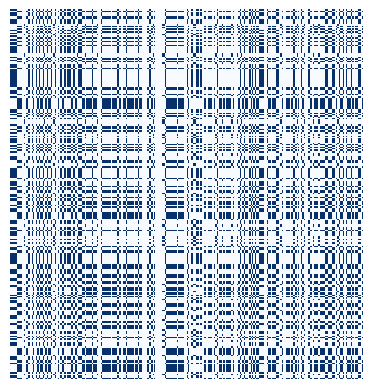

In [137]:
#sub class similarity
sub_class_similarity = (sub_left_labels[:, None] == sub_right_labels[None, :])

sns.heatmap(
    sub_class_similarity,
    cmap="Blues",
    cbar=False,
    square=True,
    xticklabels=False,
    yticklabels=False,
)

In [138]:
sub_nadine_ind_left_class_list = []
sub_nadine_ind_right_class_list = []
for i in range(n_iters):
    sub_nadine_ind_left_class, sub_nadine_ind_right_class, sub_score_class, _ = graph_match(np_sub_left_adj, np_sub_right_adj, S=sub_class_similarity, verbose=3)
    sub_nadine_ind_left_class_list.append(sub_nadine_ind_left_class)
    sub_nadine_ind_right_class_list.append(sub_nadine_ind_right_class)

[Pre-loop] Initializing
   [Pre-loop] Computing constant terms
   [Iteration: 1] Computing gradient
   [Iteration: 1] Solving assignment problem
   [Iteration: 1] Computing step size
   [Iteration: 2] Computing gradient
   [Iteration: 2] Solving assignment problem
   [Iteration: 2] Computing step size
   [Iteration: 3] Computing gradient
   [Iteration: 3] Solving assignment problem
   [Iteration: 3] Computing step size
   [Iteration: 4] Computing gradient
   [Iteration: 4] Solving assignment problem
   [Iteration: 4] Computing step size
   [Iteration: 5] Computing gradient
   [Iteration: 5] Solving assignment problem
   [Iteration: 5] Computing step size
   [Iteration: 6] Computing gradient
   [Iteration: 6] Solving assignment problem
   [Iteration: 6] Computing step size
   [Iteration: 7] Computing gradient
   [Iteration: 7] Solving assignment problem
   [Iteration: 7] Computing step size
   [Iteration: 8] Computing gradient
   [Iteration: 8] Solving assignment problem
   [Iteration: 

In [139]:
sub_score_class

5125.0

In [140]:
sub_nadine_matched_pairs_class_list = []
for i in range(n_iters):
    sub_skids_left_form_matched_class = sub_left_skids_to_match[sub_nadine_ind_left_class_list[i]]
    sub_skids_right_form_matched_class = sub_right_skids_to_match[sub_nadine_ind_right_class_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs_class = pd.DataFrame(list(zip(sub_skids_left_form_matched_class, sub_skids_right_form_matched_class)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_class_list.append(sub_nadine_matched_pairs_class)

In [141]:
#SUB, NADINE, CLASS
sub_nadine_matched_class_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_class_df = pd.merge(true_pairs, sub_nadine_matched_pairs_class_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_class_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_class_df[sub_nadine_matched_class_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_class_df[sub_nadine_matched_class_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_class_accuracy = num/den
    sub_nadine_matched_class_accuracy_list.append(sub_nadine_matched_class_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0038461538461538464
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.007692307692307693
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0038461538461538464
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0038461538461538464
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0038461538461538464
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.007692307692307693
The proportion of left right pairs from graph matching that correctly 

In [142]:
#norms of sub init class adjs
sub_nadine_matched_class_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_class_left_adj = np_sub_left_adj[np.ix_(sub_nadine_ind_left_class_list[i], sub_nadine_ind_left_class_list[i])]
    np_sub_nadine_matched_class_right_adj = np_sub_right_adj[np.ix_(sub_nadine_ind_right_class_list[i], sub_nadine_ind_right_class_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_class_diff = np_sub_nadine_matched_class_left_adj - np_sub_nadine_matched_class_right_adj
    diff_sub_nadine_matched_class_norm = np.linalg.norm(np_sub_nadine_matched_class_diff)
    sub_nadine_matched_class_norm_list.append(diff_sub_nadine_matched_class_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_class_norm}")

Norm of difference of left and right matched adjs: 80.2869852466762
Norm of difference of left and right matched adjs: 79.46068210127572
Norm of difference of left and right matched adjs: 79.66806135459805
Norm of difference of left and right matched adjs: 86.30179604156567
Norm of difference of left and right matched adjs: 79.54872720540537
Norm of difference of left and right matched adjs: 80.45495634204272
Norm of difference of left and right matched adjs: 81.24653838779841
Norm of difference of left and right matched adjs: 80.01874780324921
Norm of difference of left and right matched adjs: 80.51086883148137
Norm of difference of left and right matched adjs: 79.93122043357026


In [143]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [144]:
sub_nadine_matched_class_norm_average = np.average(sub_nadine_matched_class_norm_list)
sub_nadine_matched_class_accuracy_average = np.average(sub_nadine_matched_class_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of matched vs random sub adjacencies with class similarity (norm: 80.74), (accuracy: 0.00)')

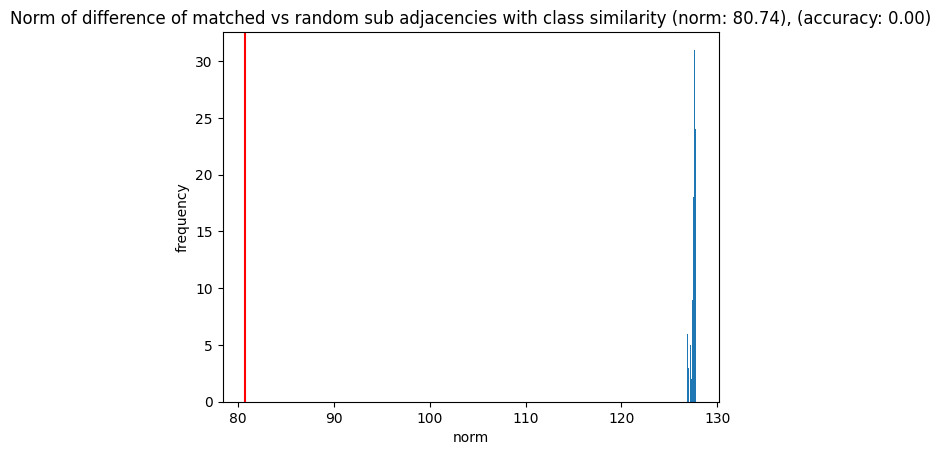

In [145]:
#histogram of WHOLE NADINE CLASS
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_class_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random sub adjacencies with class similarity (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_class_norm_average, sub_nadine_matched_class_accuracy_average))

Text(0.5, 1.0, 'Initialized Matched vs Random (Norm: 146.05), (Accuracy: 0.26)')

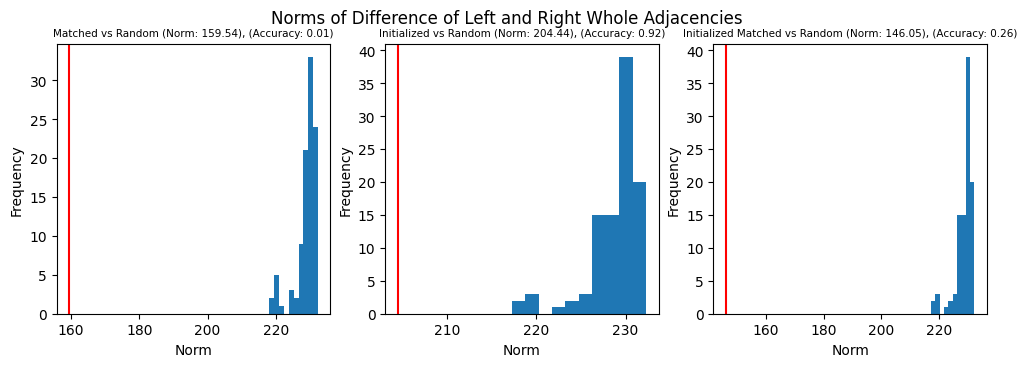

In [146]:
#whole histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
fig.suptitle("Norms of Difference of Left and Right Whole Adjacencies")

axes[0].hist(rand_norms_whole)
axes[0].axvline(norm_mean, color="r")
axes[0].set_xlabel("Norm")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Matched vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(norm_mean, accuracy_mean), fontsize=7.5)

axes[1].hist(rand_norms_whole_nadine)
axes[1].axvline(diff_whole_to_match_norm_average, color="r")
axes[1].set_xlabel("Norm")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Initialized vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average), fontsize=7.5)

axes[2].hist(rand_norms_whole_nadine)
axes[2].axvline(whole_nadine_matched_norm_average, color="r")
axes[2].set_xlabel("Norm")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Initialized Matched vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average), fontsize=7.5)

Text(0.5, 1.0, 'Norms of Differences of Whole vs Random Adjacencies')

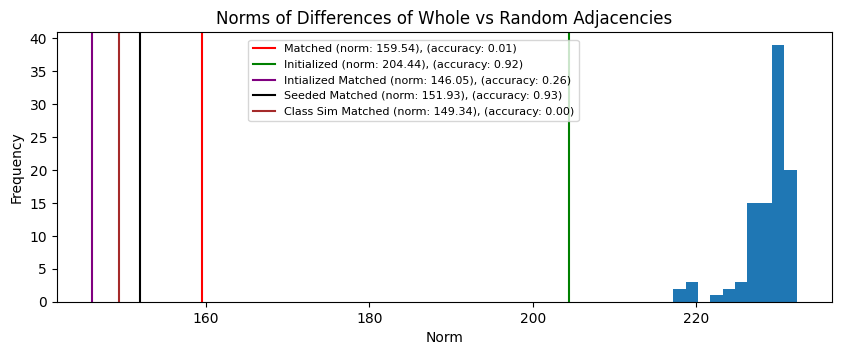

In [147]:
#whole combined histogram

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
ax.hist(rand_norms_whole_nadine)
ax.axvline(norm_mean, color="r", label="Matched (norm: {:.2f}), (accuracy: {:.2f})".format(norm_mean, accuracy_mean))
ax.axvline(diff_whole_to_match_norm_average, color="g", label="Initialized (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average))
ax.axvline(whole_nadine_matched_norm_average, color="purple", label="Intialized Matched (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))
ax.axvline(whole_nadine_matched_seed_norm_average, color="black", label="Seeded Matched (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_seed_norm_average, whole_nadine_matched_seed_accuracy_average))
ax.axvline(whole_nadine_matched_class_norm_average, color="brown", label="Class Sim Matched (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_class_norm_average, whole_nadine_matched_class_accuracy_average))
ax.set_xlabel("Norm")
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(-0.04, 0.65, 1., 0.5), fontsize=8)
ax.set_title("Norms of Differences of Whole vs Random Adjacencies")

- Fix accuracy calculation using just the known pairs
- Use functions for code
- For default cases, use intialized adjs but don't pass in init param
- Use nested for loops to iterate through combinations of parameters
- Make histograms of norms for each case using pandas
- Get rid of title of whole histogram, add details in x-axis
- Use seaborn colormap for histograms (use colormap with enough colors)
- Update graph matching summary in overleaf based on changes
- Read first flywire paper

Text(0.5, 1.0, 'Initialized Matched vs Random (norm: 68.52), (accuracy: 0.42)')

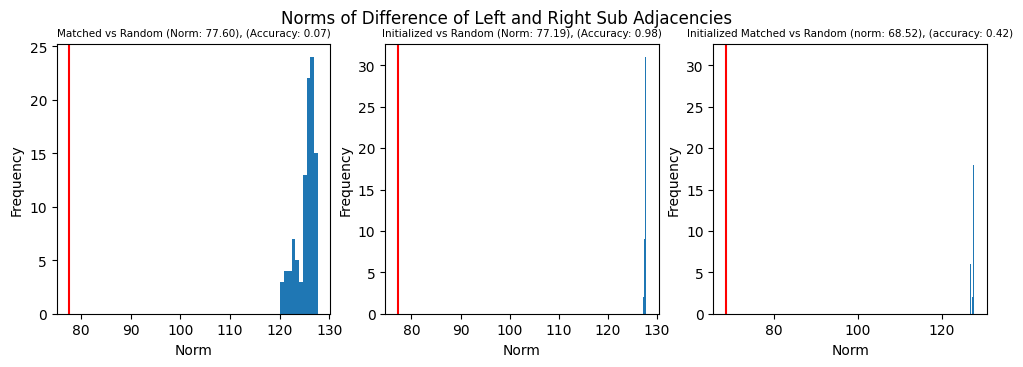

In [148]:
#sub histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
fig.suptitle("Norms of Difference of Left and Right Sub Adjacencies")

axes[0].hist(rand_norms)
axes[0].axvline(sub_matched_norm_average, color="r")
axes[0].set_xlabel("Norm")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Matched vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average), fontsize=7.5)

axes[1].hist(rand_norms_sub_nadine)
axes[1].axvline(diff_sub_to_match_norm_average, color="r")
axes[1].set_xlabel("Norm")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Initialized vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average), fontsize=7.5)

axes[2].hist(rand_norms_sub_nadine)
axes[2].axvline(sub_nadine_matched_norm_average, color="r")
axes[2].set_xlabel("Norm")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Initialized Matched vs Random (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average), fontsize=7.5)

Text(0.5, 1.0, 'Norm of Difference of Sub vs Random Adjacencies')

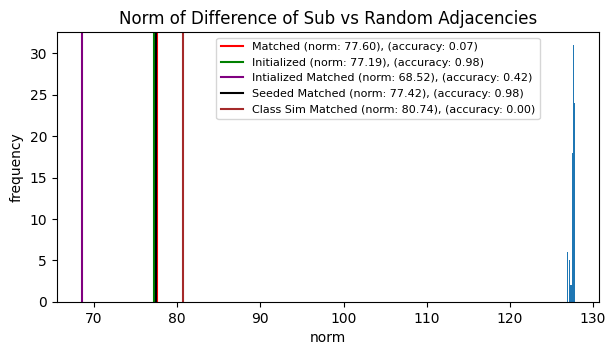

In [149]:
#wsub combined histogram

fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_matched_norm_average, color="r", label="Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average))
ax.axvline(diff_sub_to_match_norm_average, color="g", label="Initialized (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average))
ax.axvline(sub_nadine_matched_norm_average, color="purple", label="Intialized Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))
ax.axvline(sub_nadine_matched_seed_norm_average, color="black", label="Seeded Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_seed_norm_average, sub_nadine_matched_seed_accuracy_average))
ax.axvline(sub_nadine_matched_class_norm_average, color="brown", label="Class Sim Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_class_norm_average, sub_nadine_matched_class_accuracy_average))
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.legend(bbox_to_anchor=(-0.1, 0.5, 1., 0.5), fontsize=8)
ax.set_title("Norm of Difference of Sub vs Random Adjacencies")

- For the cases that I don't run graph matching, when calculating the norm, since the left and right skid list have different dimension, I chop off the last skids of the left list so the left and right lists are the same length and the pairs align
- What is labels in the paired test?